# Chapter 8 - Conditional Manatees

Lots of manatees have scars from boat propeller. Similarly, lots of WWII bombers that came back had holes from artillery or whatnot. In both cases, we'd like to reduce them damage. Naively, we should put propeller guards on boats and improve the armour where we find lots of holes.

In both cases, this is misleading.

Autopsies of manatees show that it is collisions with the blunt parts of boats (e.g. keel) that cause the most deaths. Similarly, you should increase the armour on the sections of the plane that *don't* show damage, because any of the hits there result in the plane not returning.

In both cases the evidence is misleading because it is conditional on *survival*.

**Conditioning** is one of te most important principles of statistical inference. Data are conditional on how they got into our sample! All model-based inference is conditional on the model!

Our models so far assume a degree of independence - we don't have a way to ask about, say, the effect of milk energy on brain size conditional on taxonomic group.

To model deeper conditionality - where one *predictor* depends on another *predictor* - we need **interaction** (aka **moderation**). This is a way of alloweing parameters (or more specifically, their posterior distributions) to be conditional on other aspects of the data.

More complex models (Generalized Linear Models, Multilevel models) all depend on interactions. In this chapter, we'll look at a simple example to get a feel for the idea.

## Building an Interaction

For most countries, the ruggedness of the terrain is negatively associated with log GDP. However, in Africa it is the opposite. There may be some causal reason for this - for instance, more rugged countries were more protected from the slave trade.

The DAG for this could look as follows:

In [68]:
library('ggplot2')
library('rethinking')
library('dagitty')

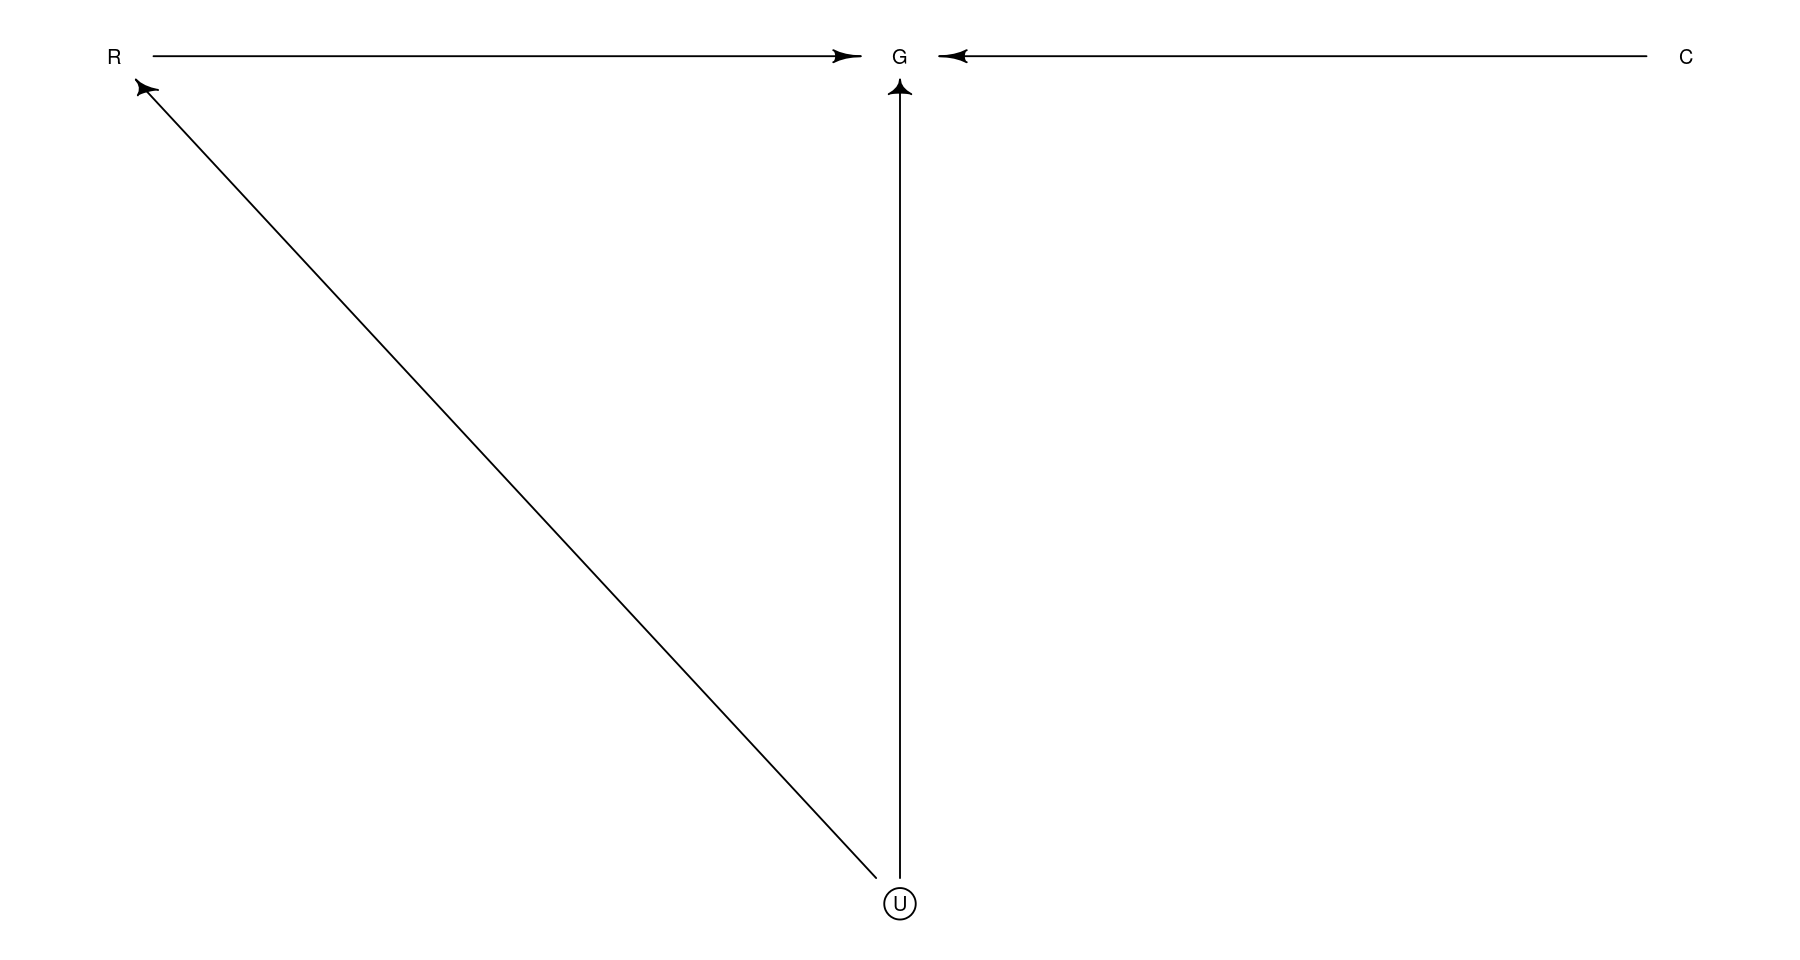

In [69]:
dag <- dagitty('dag{
    U [latent, pos="0,0"]
    R [pos="-1,-1"]
    G [pos="0,-1"]
    C [pos="1,-1"]
    U -> R -> G <- C
    U -> G
}')
drawdag(dag)

where
- $R$ is the ruggedness
- $G$ is GPD
- $C$ is the continent
- $U$ is some unobserved confounds like distance to the coast

We'll ignore $U$ for now.

The implication of this DAG is that $R$ and $C$ both affect $G$. They could do so independently or they could interact (one moderates the influence of the other). The DAG doesn't actually specify - it just says that $C = f(R, C)$; it doesn't specify the shape of the function.

So how can we make a model that produces the conditionality (ruggedness is negatively associated with GDP outside of Africa but is positively associated within it)?

We could split the dataframe into two: one for Africa and one for the rest of the world. That's a bad idea for a few reasons.
1. Some parameters, such as $\sigma$, don't (or shouldn't) depend on the continued. By splitting, you hurt the accuracy of the prediction of these parameters by essentially creating two less-ccurate estimates instead of one more-accurate one.
1. In rder to acquire probability statements about the variable we used to split (`cont_africa`), we need to include it in the model. But now, since we split on it, we can't assess any uncertainy about the predictive value of distinguishing between African and non-African countries.
1. We may want to use information criteria to assess the different models. We can only do that if the different models were trained on the same data, which would not be the case if we split this into two data frames
1. Once we start to use multilevel models, it turns out that there are advantages to 'borrowing' information across categories (like 'Africa' and 'not Africa'). This is especially true when sample sizes vary across categories, such that overfitting risk is higher within some categories.

### Making a rugged model

We'll start with a single model, ignoring continent.

In [70]:
data(rugged)
d <- rugged

# log the gdp
d$log_gdp <- log(d$rgdppc_2000)

# only get the countries with GDP data
dd <- d[complete.cases(d$rgdppc_2000),]

# rescale the variables
mean_gdp <- mean(dd$log_gdp)
dd$log_gdp_std <- dd$log_gdp / mean_gdp
dd$rugged_std <- dd$rugged / max(dd$rugged)

head(dd)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,⋯,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent,log_gdp,log_gdp_std,rugged_std
,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670,-12.299,⋯,3610000,5.669,6.981,4.926,3.872,1223208,2.000,7.492609,0.8797119,0.1383424702
5,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740,41.143,⋯,0,NA,NA,NA,NA,200000,100.000,8.216929,0.9647547,0.5525636891
8,ARE,784,United Arab Emirates,0.769,0.316,2.112,0.191,6.142,8360,23.913,⋯,0,NA,NA,NA,NA,19200,0.000,9.933263,1.1662705,0.1239922606
9,ARG,32,Argentina,0.775,0.220,2.268,0.226,9.407,273669,-35.396,⋯,0,NA,NA,NA,NA,276632,89.889,9.407032,1.1044854,0.1249596904
10,ARM,51,Armenia,2.688,0.934,8.178,0.799,50.556,2820,40.294,⋯,0,NA,NA,NA,NA,105743,0.500,7.792343,0.9149038,0.4334085779
12,ATG,28,Antigua and Barbuda,0.006,0.003,0.012,0.003,0.000,44,17.271,⋯,0,NA,NA,NA,NA,747,NA,9.212541,1.0816501,0.0009674299


Each row is a country.

Normally we would rescale by making each into a z-score. However, we want these values (ruggedness and gpd) to be relevant to humans. That means that we score the ruggedness from 0 (totally flat) to 1 (the most rugged country, which happens to be Losotho). The GDP is similarly scale to be a proportion of the average.

Model:

$$
\begin{align*}
\log (y_i) &\sim \text{Normal}(\mu_i, sigma) \\
\mu_i &= \alpha + \beta(r_i - \bar{r})
\end{align*}
$$

Now we need the priors. I don't know much a priori about the relationship betwen ruggedness and GPD. Luckily, we can lean on the data a bit.

Let's look at the intercept $\alpha$. This is the log GDP when the ruggedness is at the mean. This should be close to 1, since we scaled it that way. Let's guess at
$$
\alpha \sim \text{Normal}(1, 1)
$$

For $\beta$, we can start with a mean of 0 (no positive or negative bias). What about the standard deviation? Again, we'll guess at 1. Then
$$
\beta \sim \text{Normal}(0, 1)
$$

We'll also take a broad guess at $\sigma$:

$$
\sigma \sim \text{Exponential}(1)
$$

In [71]:
m8.1 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a + b * (rugged_std - 0.215),
        a ~ dnorm(1, 1),
        b ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=dd
)

In [72]:
# prior predictive check
set.seed(7)
prior <- extract.prior(m8.1)

# grab 50 lines from the prior
rugged_seq <- seq(from=-0.1, to=1.1, length.out=30)
mu <- link(m8.1, post=prior, data=data.frame(rugged_std=rugged_seq))

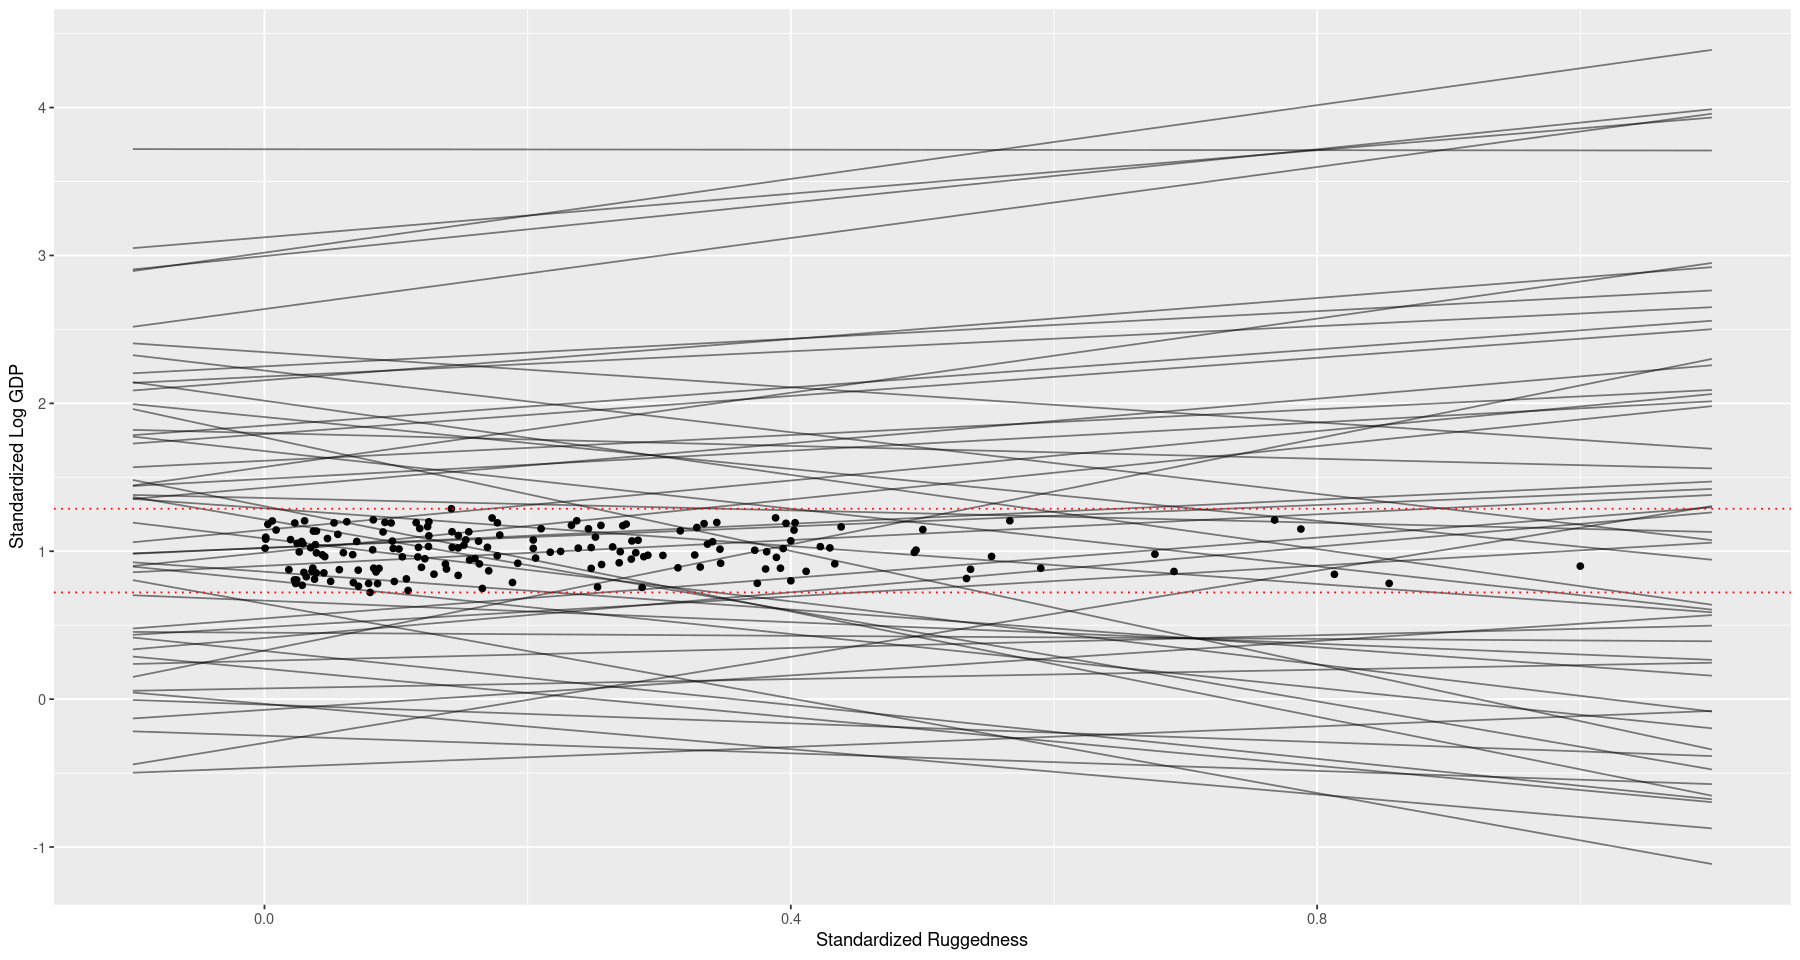

In [73]:
lines_df <- data.frame(rugged_std=double(), log_gdp_std=double(), group=integer())

for ( i in 1:50 ) {
    new_lines_df = data.frame(rugged_std=rugged_seq, log_gdp_std=mu[i,], group=i)
    lines_df <- rbind(lines_df, new_lines_df)
}
lines_df$group <- as.factor(lines_df$group)
ggplot() +
    geom_point(data=dd, aes(rugged_std, log_gdp_std)) + # data
    geom_line(data=lines_df, aes(rugged_std, log_gdp_std, group=group), alpha=0.5) + # regression lines
    geom_hline(yintercept = min(dd$log_gdp_std), linetype='dotted', colour='red') +
    geom_hline(yintercept = max(dd$log_gdp_std), linetype='dotted', colour='red') +
    xlab("Standardized Ruggedness") +
    ylab("Standardized Log GDP")


As you can see, this is some nonsense. We need a tighter standard deviation on the $\alpha$ prior. Maybe something like $\sigma \sim \text{Normal}(0, 0.1)$? This would put most of the weight between the observed values (0.8 - 1.2).

Also, the slopes are too variable. It is just not plausible that *most* of the variation that we see is due to ruggedness. We need to tighten up the $\beta$ prior as well. Maybe $\beta \sim \text{Normal}(0, 0.3)$?

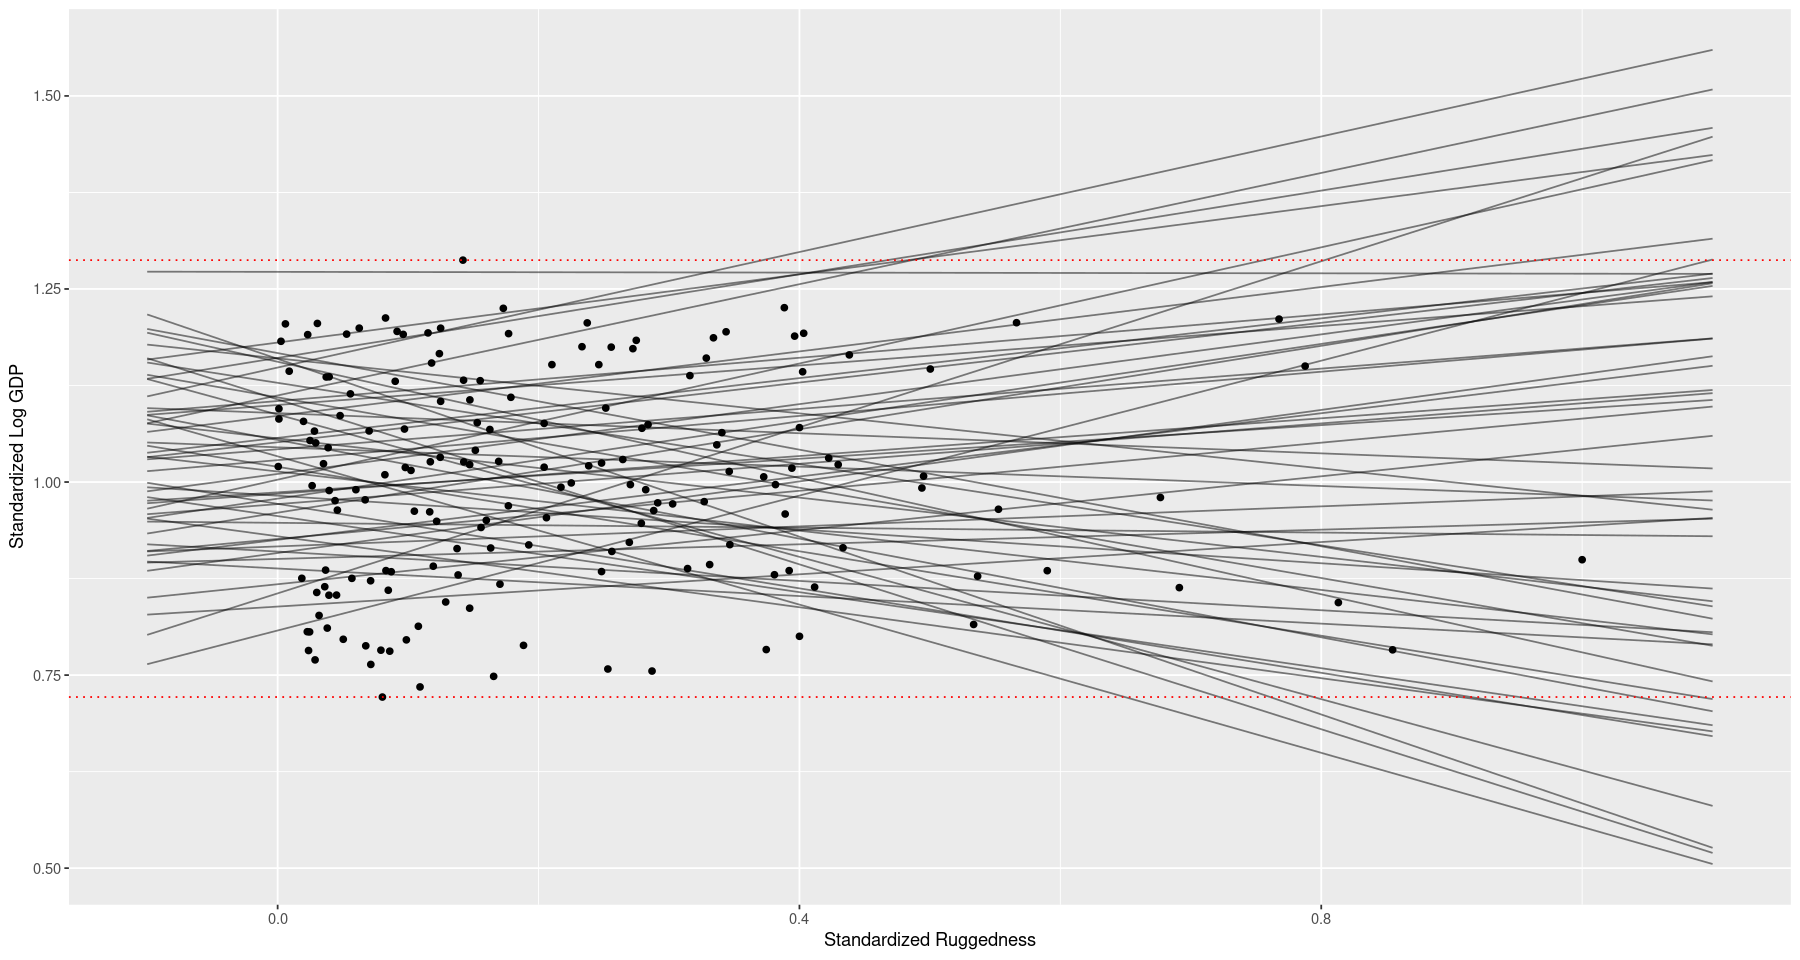

In [74]:
m8.1 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a + b * (rugged_std - 0.215),
        a ~ dnorm(1, 0.1),
        b ~ dnorm(0, 0.3),
        sigma ~ dexp(1)
    ),
    data=dd
)

set.seed(7)
prior <- extract.prior(m8.1)

# grab 50 lines from the prior
rugged_seq <- seq(from=-0.1, to=1.1, length.out=30)
mu <- link(m8.1, post=prior, data=data.frame(rugged_std=rugged_seq))

lines_df <- data.frame(rugged_std=double(), log_gdp_std=double(), group=integer())

for ( i in 1:50 ) {
    new_lines_df = data.frame(rugged_std=rugged_seq, log_gdp_std=mu[i,], group=i)
    lines_df <- rbind(lines_df, new_lines_df)
}
lines_df$group <- as.factor(lines_df$group)
ggplot() +
    geom_point(data=dd, aes(rugged_std, log_gdp_std)) + # data
    geom_line(data=lines_df, aes(rugged_std, log_gdp_std, group=group), alpha=0.5) + # regression lines
    geom_hline(yintercept = min(dd$log_gdp_std), linetype='dotted', colour='red') +
    geom_hline(yintercept = max(dd$log_gdp_std), linetype='dotted', colour='red') +
    xlab("Standardized Ruggedness") +
    ylab("Standardized Log GDP")

This seems much more plausible.

In [75]:
precis(m8.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.999999515,0.010411972,0.9833592,1.01663986
b,0.001990935,0.054793464,-0.0855796,0.08956147
sigma,0.136497402,0.007396152,0.1246769,0.14831788


From this, we see no association between terrain ruggedness and log GPD.

### Adding an indicator variable isn't enough

Just adding an indicator variable, `cont_africa`, isn't enough. Let's see that not working!

We need to make it so that the model has two intercepts: one for in Africa and one for out.

$$
\mu_i = \alpha_{CID[i]} + \beta(r_i - \bar{r})
$$

where $CID[i]$ is the continent indicator ($i$ is 1 or 2) for the $i$th row.

In [76]:
# variable to index Africa (1) or not (2)
dd$cid <- ifelse(dd$cont_africa==1, 1, 2)

In [77]:
m8.2 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b ~ dnorm(0, 0.3),
        sigma ~ dexp(1)
    ),
    data=dd
)

In [78]:
# compare using WAIC
compare(m8.1, m8.2)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m8.2,-252.2687,15.30518,0.00000,NA,4.258517,1.000000e+00
m8.1,-188.7542,13.29295,63.51448,15.14678,2.690401,1.614382e-14


The standard error of the weight is 15, and the actual difference is 63.5 - this is pretty important! It looks like the continent indicator is picking up some important information.

In [79]:
precis(m8.2, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.88041284,0.015937003,0.8549424,0.90588325
a[2],1.04916425,0.010185554,1.0328858,1.06544274
b,-0.04651347,0.045686725,-0.1195297,0.02650274
sigma,0.11238738,0.006091077,0.1026527,0.12212209


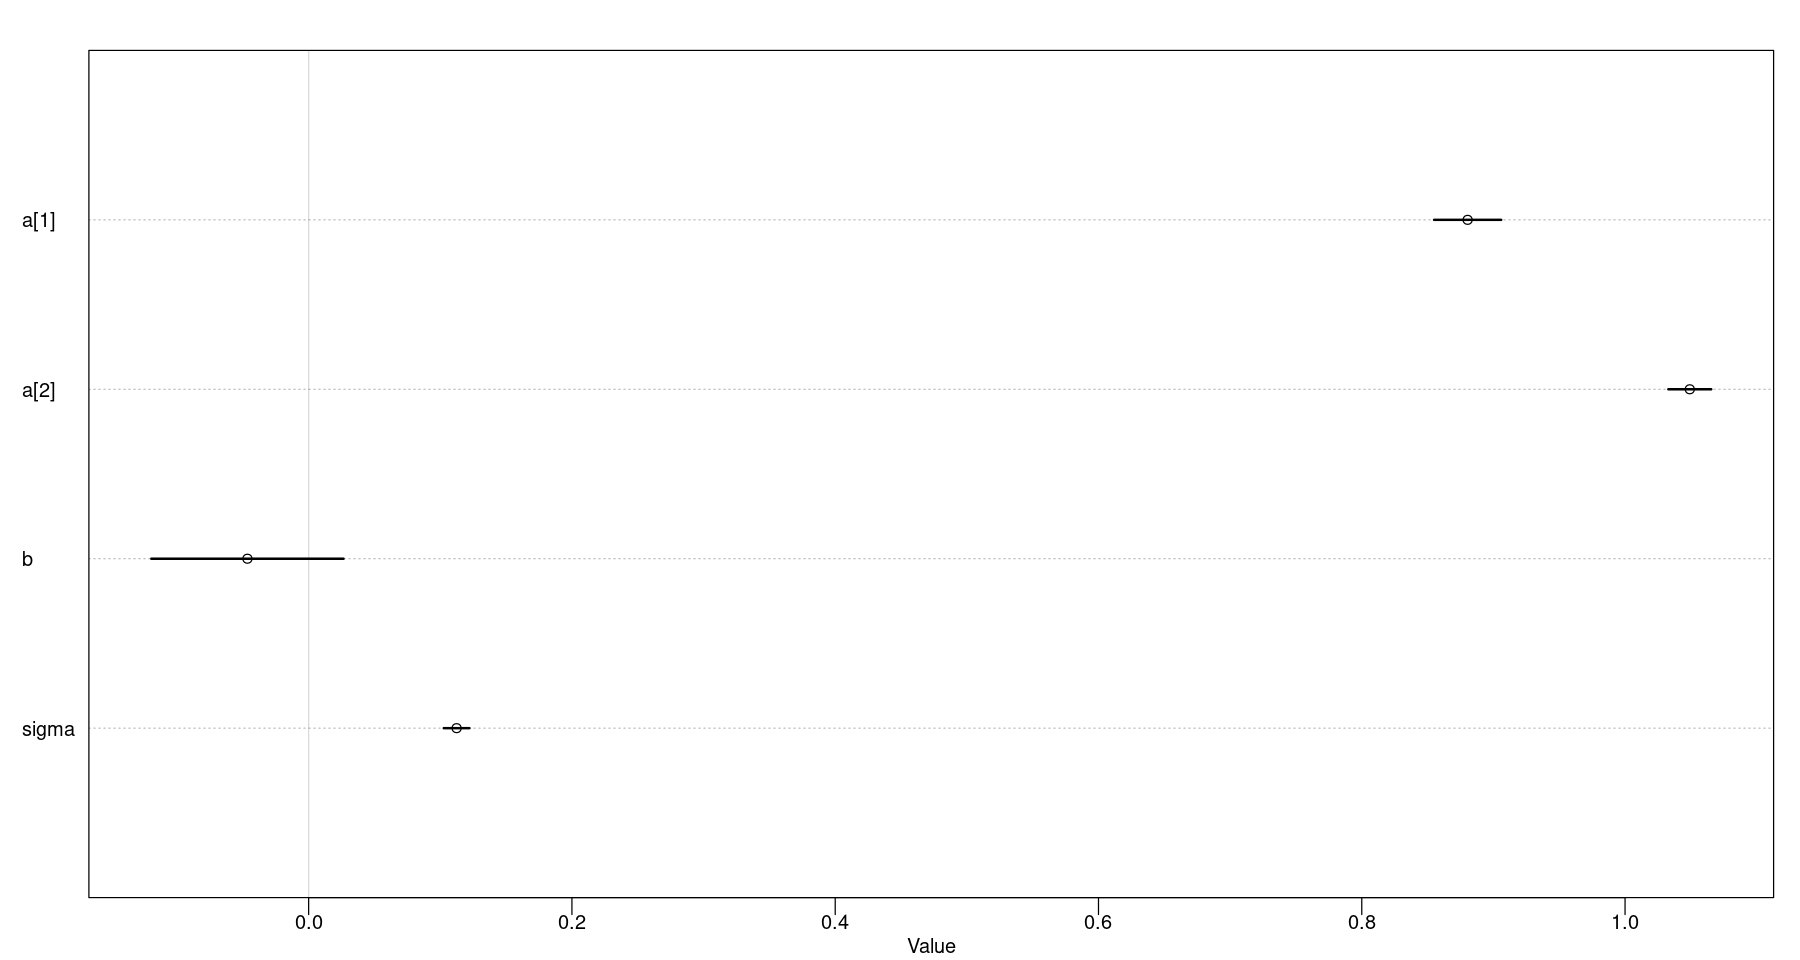

In [80]:
plot(precis(m8.2, depth=2))

The parameter $a[1]$ is for African nations and seems reliably lower than the one for non-African nations. The posterior contrast between the two is

In [81]:
post <- extract.samples(m8.2)
diff_a1_a2 <- post$a[,1] - post$a[,2]
PI(diff_a1_a2)

5%        94% 
-0.1990118 -0.1378490

So the difference seems reliably negative. Now let's graph this to see what the effect looks like.

In [82]:
rugged_seq <- seq(from=-0.1, to=1.1, length.out=30)
# compute the means over the samples, fixing CID=1 and then 2
mu.Africa <- link(m8.2, data=data.frame(cid=1, rugged_std=rugged_seq))
mu.NotAfrica <- link(m8.2, data=data.frame(cid=2, rugged_std=rugged_seq))

# summarize the means and intervals
mu.NotAfrica_mu <- apply(mu.NotAfrica, 2, mean)
mu.NotAfrica_ci <- apply(mu.NotAfrica, 2, PI, prob=0.97)
mu.Africa_mu <- apply(mu.Africa, 2, mean)
mu.Africa_ci <- apply(mu.Africa, 2, PI, prob=0.97)

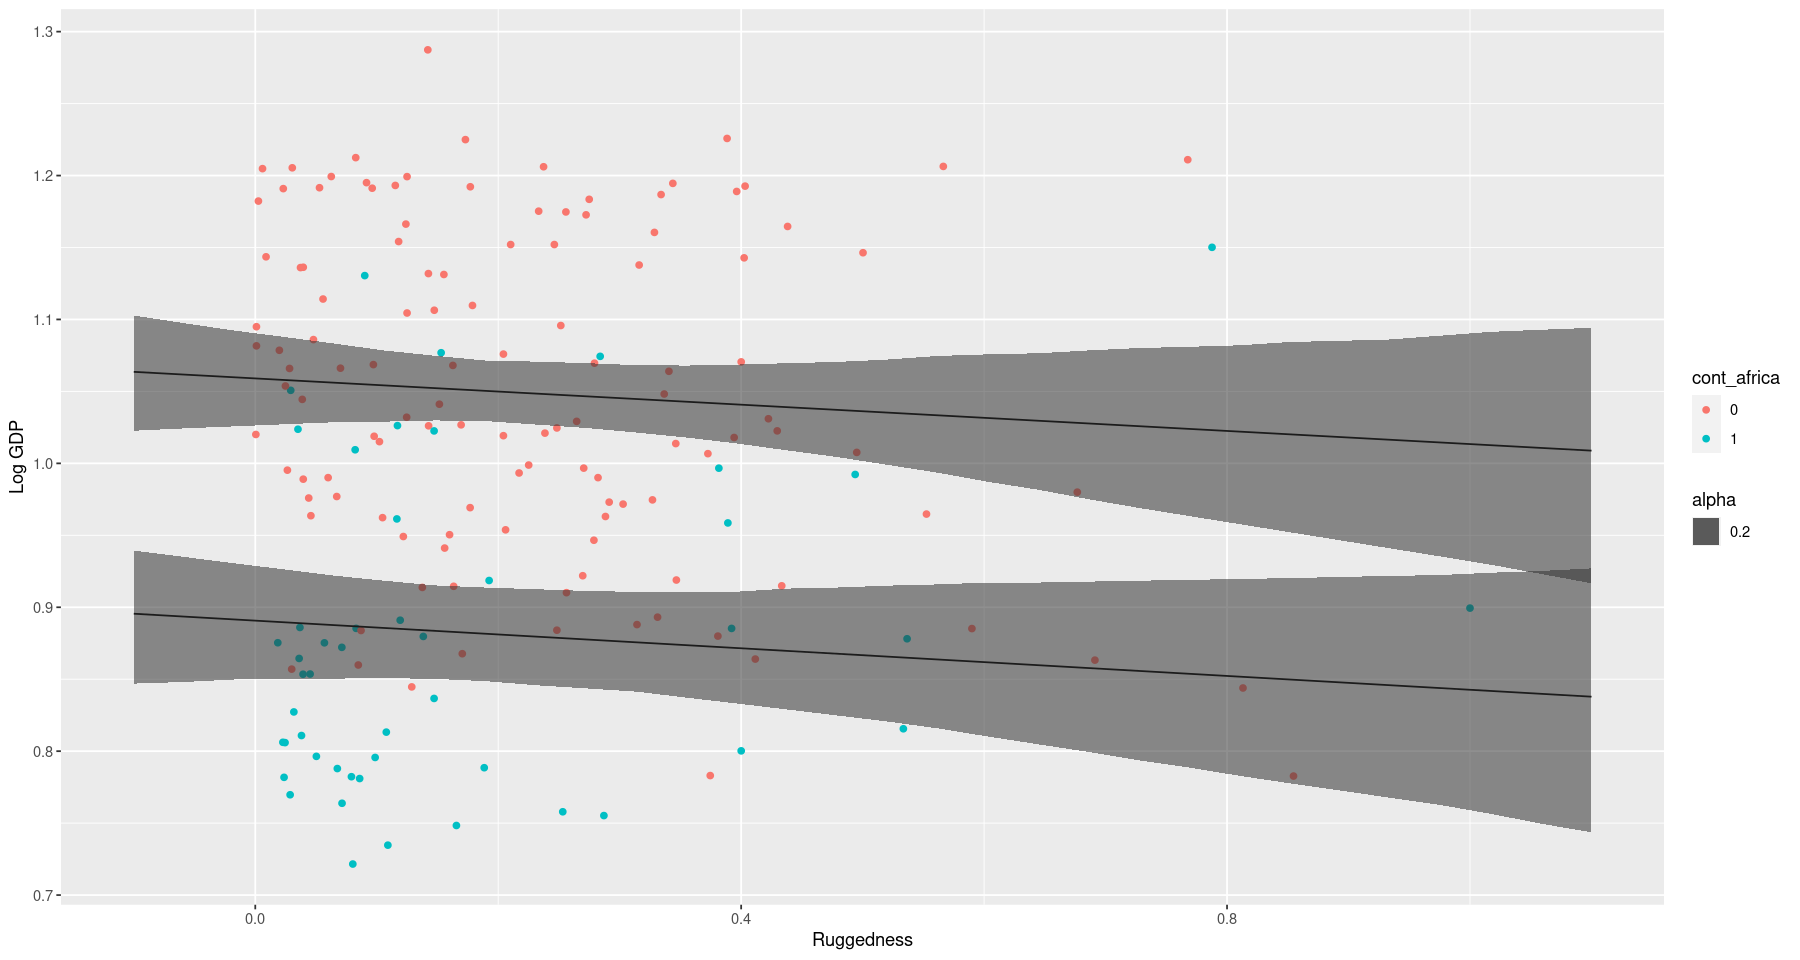

In [83]:
dd$cont_africa <- as.factor(dd$cont_africa)
ggplot() +
    geom_point(data=dd, aes(rugged_std, log_gdp_std, colour=cont_africa)) +
    geom_line(data=data.frame(rugged_std=rugged_seq, log_gpd_std=mu.NotAfrica_mu), aes(rugged_std, log_gpd_std)) +
    geom_ribbon(data=data.frame(rugged_std=rugged_seq, lower=mu.NotAfrica_ci[1,], upper=mu.NotAfrica_ci[2,]), aes(
        rugged_std, ymin=lower, ymax=upper, alpha=0.2
    )) +
    geom_line(data=data.frame(rugged_std=rugged_seq, log_gpd_std=mu.Africa_mu), aes(rugged_std, log_gpd_std)) +
    geom_ribbon(data=data.frame(rugged_std=rugged_seq, lower=mu.Africa_ci[1,], upper=mu.Africa_ci[2,]), aes(
        rugged_std, ymin=lower, ymax=upper, alpha=0.2
    )) +
    xlab('Ruggedness') +
    ylab("Log GDP")

Because we only allowed the intercept to change, the slopes are identical. However, we do see a lower GPD level in the African countries. So how can we add the interaction to recover the change in slope that we saw earlier? We'll just double down and allow the slope to also be indexed to the continent indicator!

$$
\mu_u = \alpha_{CID[i]} + \beta_{CID[i]} * (r_i - \bar{r})
$$

In [84]:
m8.3 <- quap(
    alist(
        log_gdp_std ~ dnorm(mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(0, 0.3),
        sigma ~ dexp(1)
    ),
    data=dd
)

In [85]:
precis(m8.3, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],0.8865442,0.015676378,0.86149028,0.91159804
a[2],1.0505689,0.009937071,1.03468758,1.06645030
b[1],0.1326132,0.074207629,0.01401504,0.25121129
b[2],-0.1427253,0.054751746,-0.23022921,-0.05522148
sigma,0.1094993,0.005935989,0.10001242,0.11898613


So here we see that the slopes are nerly reversed: 0.13 vs. -0.14. Let's use PSIS to compare the models. We use PSIS because of the Pareto-$k$ warnings.

In [86]:
compare(m8.1, m8.2, m8.3, func=PSIS)

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m8.3,-259.1326,15.21911,0.00000,NA,5.166182,9.716174e-01
m8.2,-252.0662,15.40450,7.06637,6.670773,4.340923,2.838263e-02
m8.1,-188.5944,13.37393,70.53821,15.453690,2.750823,4.680775e-16


The model m8.3 has almost all of the weight (97%), which is very strong support for including the interaction (as long as our goal is prediction). The slight weight given to m8.2 indicates that the slopes in m8.3 are slightly overfit. And notice that the difference in the top two models (6.7) is basically the same as the standard error (7.5). Let's look at the pareto $k$ values.

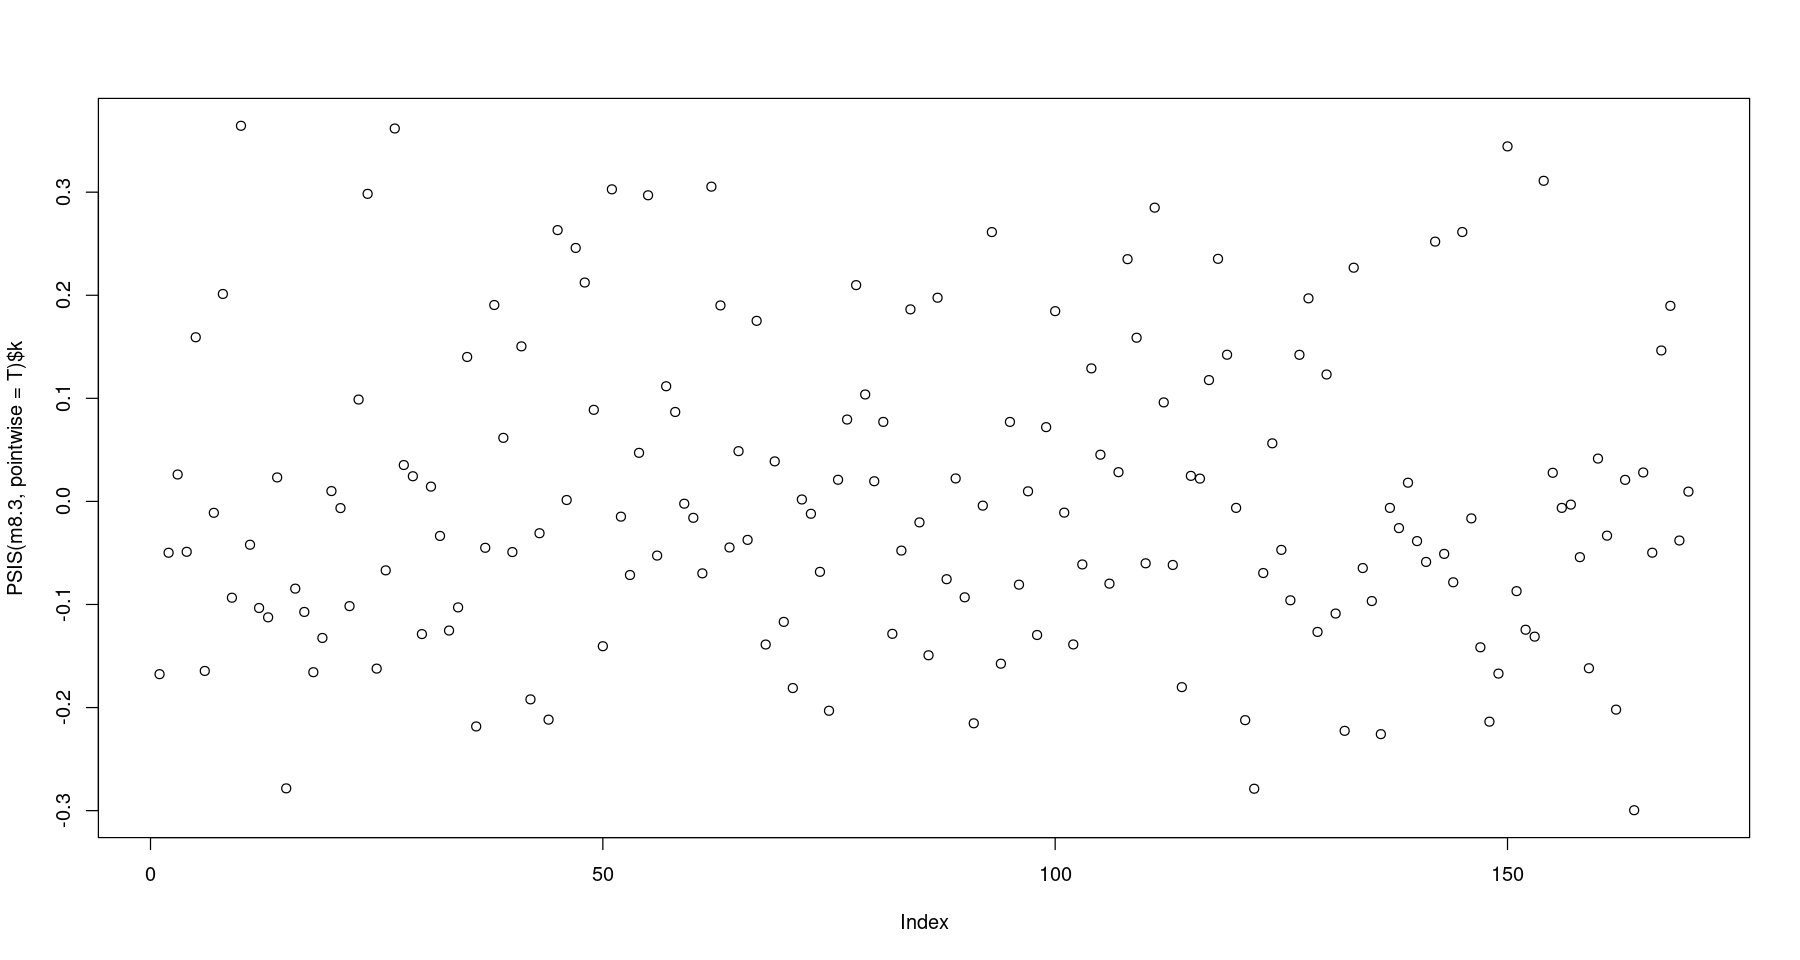

In [87]:
plot(PSIS(m8.3, pointwise=T)$k)

This might be a place to use robust regression (like the Student-t one that we used in the previous chapter).

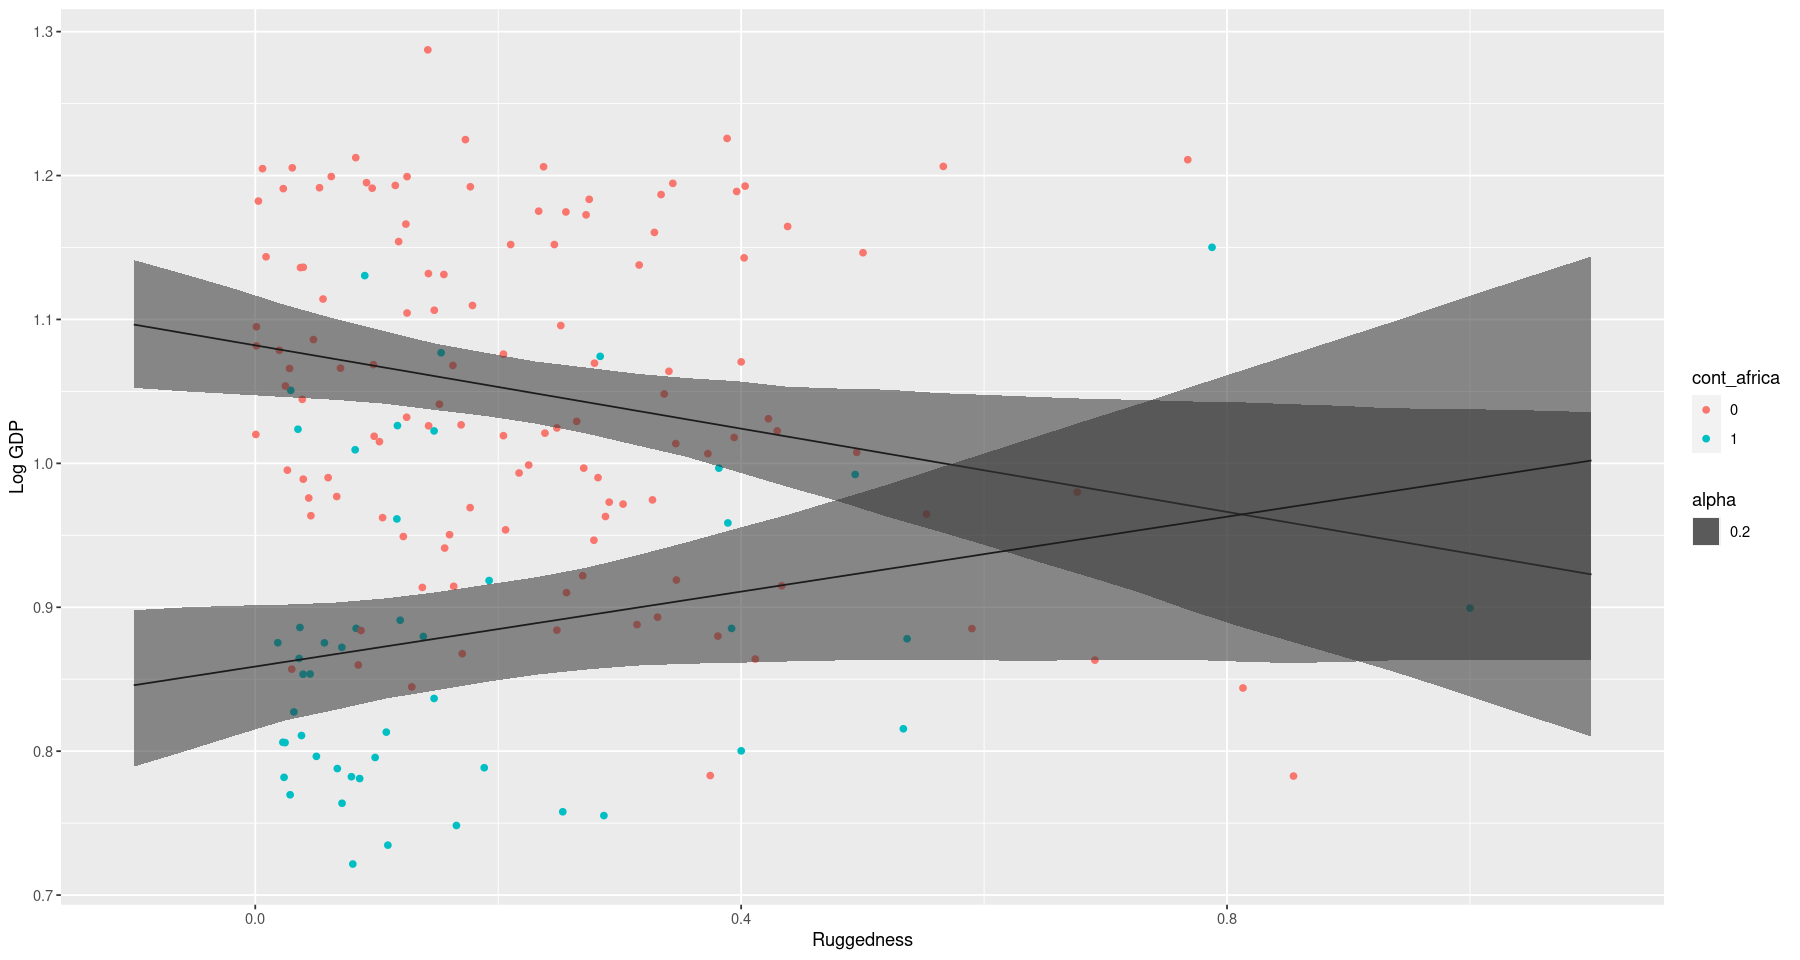

In [88]:
rugged_seq <- seq(from=-0.1, to=1.1, length.out=30)
# compute the means over the samples, fixing CID=1 and then 2
mu.Africa <- link(m8.3, data=data.frame(cid=1, rugged_std=rugged_seq))
mu.NotAfrica <- link(m8.3, data=data.frame(cid=2, rugged_std=rugged_seq))

# summarize the means and intervals
mu.NotAfrica_mu <- apply(mu.NotAfrica, 2, mean)
mu.NotAfrica_ci <- apply(mu.NotAfrica, 2, PI, prob=0.97)
mu.Africa_mu <- apply(mu.Africa, 2, mean)
mu.Africa_ci <- apply(mu.Africa, 2, PI, prob=0.97)

ggplot() +
    geom_point(data=dd, aes(rugged_std, log_gdp_std, colour=cont_africa)) +
    geom_line(data=data.frame(rugged_std=rugged_seq, log_gpd_std=mu.NotAfrica_mu), aes(rugged_std, log_gpd_std)) +
    geom_ribbon(data=data.frame(rugged_std=rugged_seq, lower=mu.NotAfrica_ci[1,], upper=mu.NotAfrica_ci[2,]), aes(
        rugged_std, ymin=lower, ymax=upper, alpha=0.2
    )) +
    geom_line(data=data.frame(rugged_std=rugged_seq, log_gpd_std=mu.Africa_mu), aes(rugged_std, log_gpd_std)) +
    geom_ribbon(data=data.frame(rugged_std=rugged_seq, lower=mu.Africa_ci[1,], upper=mu.Africa_ci[2,]), aes(
        rugged_std, ymin=lower, ymax=upper, alpha=0.2
    )) +
    xlab('Ruggedness') +
    ylab("Log GDP")

So here we can see the recovered slopes are different - negative outside Africa but positive within it!

## Symmetry of Interactions

There are two symmetrical ways of interpreting what we just did:
1. How much does the association between ruggedness and log GDP depend on whether the nation is in Africa?
1. How much does the association of Africa with log GDP depend on ruggedness?

Let's look at the definition of $\mu_i$ again:

$$
\mu_i = \alpha_{CID[i]} + \beta_{CID[i]}(r_i - \bar{r})
$$

The way we've interpreted this is as the slope being conditional on the continent. To see the other way, let's re-write this slightly:

$$
\mu_i = \underbrace{(2 - \text{CID})(\alpha_1 + \beta_1 (r_i - \bar{r}))}_{\text{$CID[i]$ = 1}} + \underbrace{(1 - \text{CID})(\alpha_2 + \beta_2 (r_i - \bar{r}))}_{\text{$CID[i]$ = 2}}
$$

This is actually the same model, but now it's more aparent that this depends on the ruggedness. Now if we imagine switching a nation to Africa, in order to know what this does for the prediction, we have to know the ruggedness.

Let's plot the reverse interpretation: *the association of being in Africa with log GDP depends upon terrain ruggedness*. We'll computer the difference between a nation in Africa and one outside it and display the results.

In [89]:
rugged_seq <- seq(from=-0.2, to=1.2, length.out=30)
muA <- link(m8.3, data=data.frame(cid=1, rugged_std=rugged_seq))
muN <- link(m8.3, data=data.frame(cid=2, rugged_std=rugged_seq))
delta <- muA - muN
head(delta)
delta_mu <- apply(delta, 2, mean)
delta_ci <- apply(delta, 2, PI, prob=0.97)

-0.2718117,-0.2589063,-0.2460009,-0.2330955,-0.2201901,-0.2072847,-0.1943793,-0.1814739,-0.1685685,-0.1556631,⋯,-0.013703740,-0.0007983435,0.01210705,0.02501245,0.03791785,0.05082324,0.063728639,0.076634036,0.08953943,0.10244483
-0.3282910,-0.3098404,-0.2913898,-0.2729392,-0.2544886,-0.2360380,-0.2175874,-0.1991368,-0.1806863,-0.1622357,⋯,0.040720823,0.0591714132,0.07762200,0.09607259,0.11452318,0.13297377,0.151424362,0.169874952,0.18832554,0.20677613
-0.3597178,-0.3420106,-0.3243034,-0.3065962,-0.2888891,-0.2711819,-0.2534747,-0.2357675,-0.2180603,-0.2003531,⋯,-0.005574033,0.0121331551,0.02984034,0.04754753,0.06525472,0.08296191,0.100669098,0.118376287,0.13608348,0.15379066
-0.2162713,-0.2080968,-0.1999224,-0.1917479,-0.1835735,-0.1753990,-0.1672245,-0.1590501,-0.1508756,-0.1427011,⋯,-0.052782044,-0.0446075813,-0.03643312,-0.02825866,-0.02008419,-0.01190973,-0.003735267,0.004439196,0.01261366,0.02078812
-0.3223655,-0.3041704,-0.2859752,-0.2677801,-0.2495850,-0.2313899,-0.2131947,-0.1949996,-0.1768045,-0.1586094,⋯,0.041537000,0.0597321247,0.07792725,0.09612237,0.11431750,0.13251262,0.150707747,0.168902871,0.18709800,0.20529312
-0.2977979,-0.2800330,-0.2622681,-0.2445032,-0.2267383,-0.2089734,-0.1912085,-0.1734436,-0.1556786,-0.1379137,⋯,0.057500325,0.0752652390,0.09303015,0.11079507,0.12855998,0.14632489,0.164089807,0.181854721,0.19961963,0.21738455


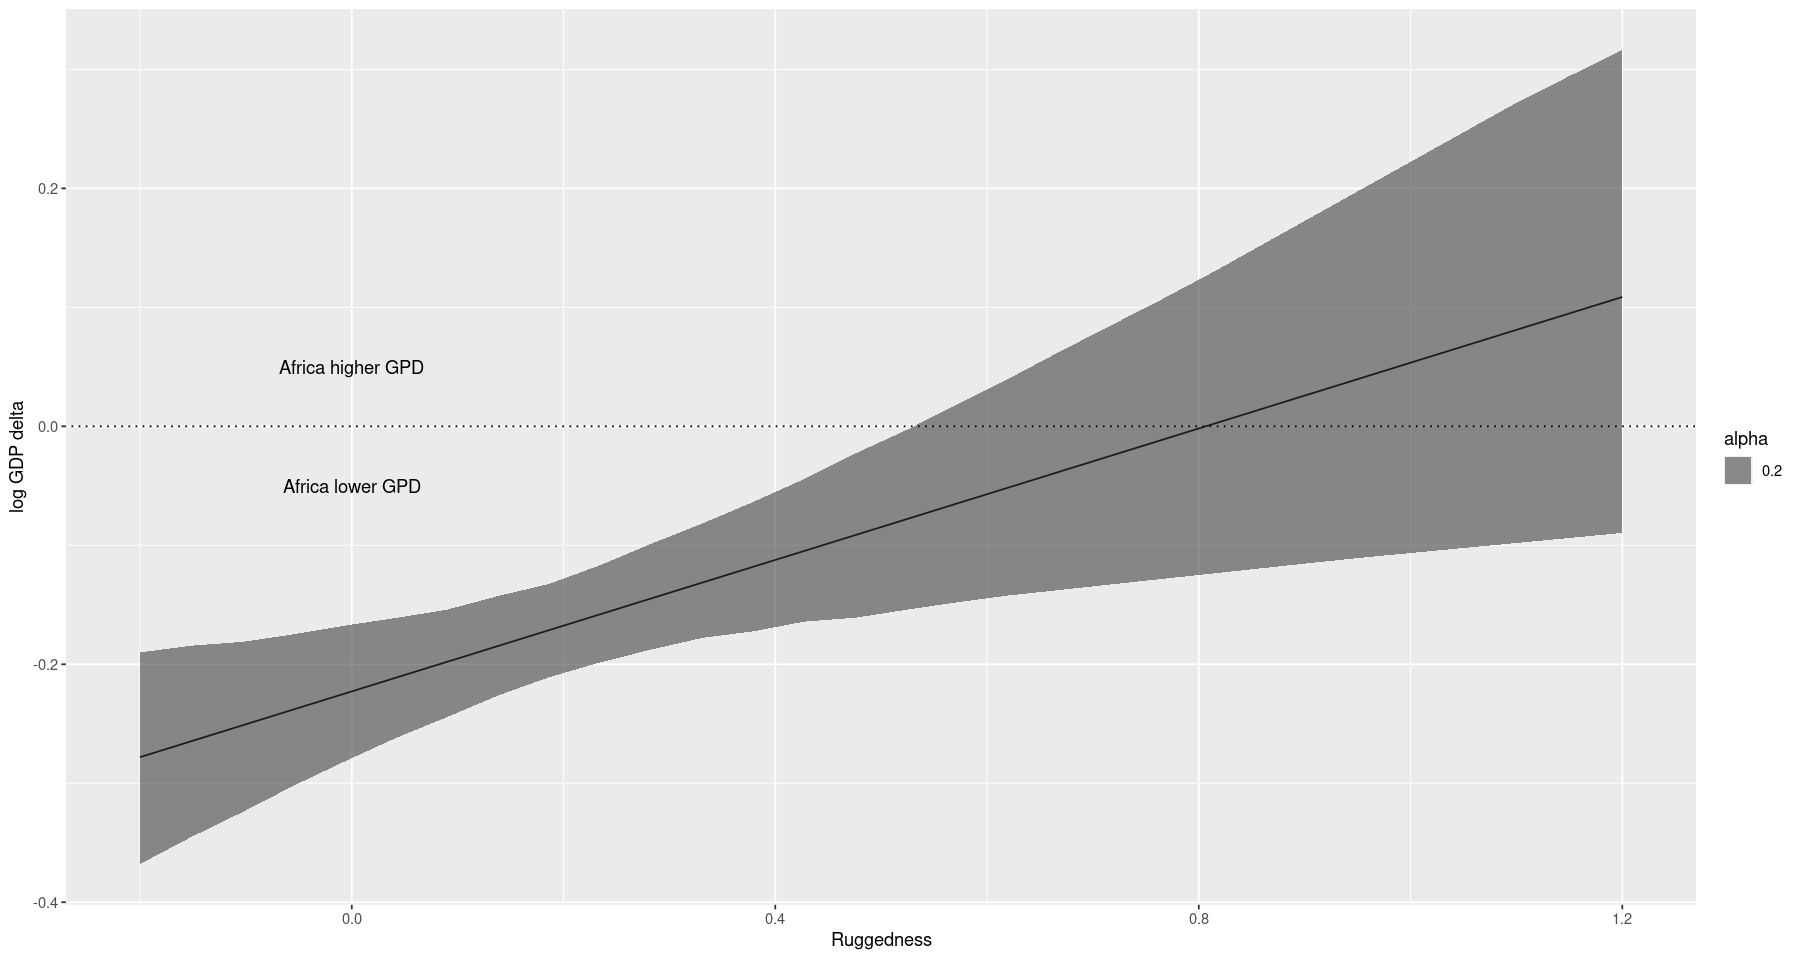

In [90]:
plot_df <- data.frame(
    rugged=rugged_seq,
    log_gdp_delta=delta_mu,
    lower=delta_ci[1,],
    upper=delta_ci[2,]
)
ggplot(plot_df, aes(rugged)) +
    geom_line(aes(y=log_gdp_delta)) +
    geom_ribbon(aes(ymin=lower, ymax=upper, alpha=0.2)) +
    geom_abline(aes(slope=0, intercept=0), linetype='dotted') +
    annotate('text', x=0, y=0.05, label="Africa higher GPD") +
    annotate('text', x=0, y=-0.05, label="Africa lower GPD") +
    xlab("Ruggedness") +
    ylab("log GDP delta")

From this, we can see that it's really only at very high levels of ruggedness thata  country would be better to be in Africa.

So really, there's no difference between these interpretations - they are the same. Use the one that feels more natural.

## Continuous Interaction

So far we've been dealing with a discrete interaction: the continent. However, interactions in general are very difficult to interpret. We'll take a look at constructing and interpreting a continuous interaction.

### A Winter Flower

The data in this example are te sizes of blooms from begs of tulips grown in a greenhouse under different soil and light conditions.

In [91]:
data(tulips)
d <- tulips
str(d)

'data.frame':	27 obs. of  4 variables:
 $ bed   : Factor w/ 3 levels "a","b","c": 1 1 1 1 1 1 1 1 1 2 ...
 $ water : int  1 1 1 2 2 2 3 3 3 1 ...
 $ shade : int  1 2 3 1 2 3 1 2 3 1 ...
 $ blooms: num  0 0 111 183.5 59.2 ...


The `blooms` variable will be the outcome we want to predict, and `water` and `shade` will be the predictor variables. `water` indicates one of three ordered levels of soil moisture, from low (1) to high (3). `shade` indicates three ordered levels of light exposure, from low (1) to high (3). `bed` indicates a cluster of plants fro the same section of the greenhouse.

We expect `water` and `shade` to help plants grow. *However*, we also expect an interaction between them - increasing the water if there is no light is unlikely to help.

### The models

We'll focus on two models: one with both variables but no interactions, and one with the interactions.

The causal scenario is simple: $W \to B \leftarrow S$. The DAG doesn't tell us about the shape of the function $B = f(S, W)$. In principle, every unique combination of $S$ and $W$ could have its own mean, &c. We'll start simple.

$$
\begin{align*}
B_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_W(W_i - \bar{W}) + \beta_S(S_i - \bar{S})
\end{align*}
$$

In [92]:
d$blooms_std <- d$blooms / max(d$blooms)
d$water_cent <- d$water - mean(d$water)
d$shade_cent <- d$shade - mean(d$shade)

Now we need some priors! A vague guess:

$$
\begin{align*}
\alpha &\sim \text{Normal}(0.5, 1) \\
\beta_W &\sim \text{Normal}(0, 1) \\
\beta_S &\sim \text{Normal}(0, 1)
\end{align*}
$$

Centring $\alpha$ at 0.5 implies that if $S$ and $W$ are at their mean values, the blooms will be about half of the maximum size. Centring $\beta_S$ and $\beta_W$ at 0 means that we make no assumptions about the direction of the effect, even though logically we expect that the effect of water should be positive and the effect of shade should be negative.

The prior standard deviations seem too broad. For instance, $\alpha$ should be between 0 and 1. But...

In [93]:
# most of the weight is outside this range!
a <- rnorm(1e4, 0.5, 1)
sum(a < 0 | a > 1) / length(a)

[1] 0.6164

In [94]:
# changing the std to 0.25 will constrain the mass
a <- rnorm(1e4, 0.5, 0.25)
sum(a < 0 | a > 1) / length(a)

[1] 0.0473

What about the slopes? The range of both water and shade is 2. In order to go from the minimum (0 blooms) to the maximum (1) in the two units of change would require a slope of 0.5. Assigning a std of 0.25 would make this 2 std from the mean, putting most of the mass in this range.

In [95]:
m8.4 <- quap(
    alist(
        blooms_std ~ dnorm(mu, sigma),
        mu <- a + bw * water_cent + bs * shade_cent,
        a ~ dnorm(0.5, 0.25),
        bw ~ dnorm(0, 0.25),
        bs ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)

Before we actually plot this (&c.), let's build the interaction model. We want the mean for the water slope to depend on the level of shade, *but* we also want the shade slope to depend on the level of water. How can we do this?

Basically, we'll have a linear model inside our linear model. So, to make the slope conditional on another variable, we ust make another linear model in that!

Say $W_i$ and $S_i$ are the centred models. Then we can define the slope $\beta_W$ with its own linear model $\gamma_W$:

$$
\begin{align*}
\mu_i &= \alpha + \gamma_{W,i}W_i + \beta_S S_i \\
\gamma_{W,i} &= \beta_W + \beta_{WS} S_I \\
\end{align*}
$$

Now $\gamma_{W,i}$ is the slope defining how quickly blooms change with water level. The parameter $\beta_W$ is the rate of change, when shade is at its mean value, and $\beta_{WS}$ is the rate of change in $\gamma_{W,i}$ as shade chagnes - the shope for shade on the slope of water.

Now we also want the shade to depend on water. Luckily, we get this for free - once you make $z$ conditional on $x$, $x$ is automatically conditional on $z$.

So now we can just sub this into our equation:

$$
\mu_i = \alpha + \underbrace{( \beta_W + \beta_{WS}S_i )}_{\gamma_{W,i}}W_i + \beta_S S_i = \alpha + \beta_W W_i + \beta_S S_i + \beta_{WS}S_i W_i
$$

That last part is the conventional for form a continuous interaction - a term containing the product of the two variables with its own slope variable.

Our new model:

$$
\begin{align*}
B_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_W W_i + \beta_S S_i + \beta_{WS} W_i S_i
\end{align*}
$$

Now we need a prior! This is a bit tricky, since there isn't really a natural interpretation for $\beta_{WS}$. However, we can work with implied predictions. Say that the strongest effect is one in which enough shade makes the water have zero effect. Then $\gamma_{W,i} = \beta_W + \beta_{WS} S_i = 0$. If we then set $S_i = 1$ (the max), then $\beta_W + \beta_{WS}(1) = 0 \to \beta_{WS} = -\beta_W$.

In code:


In [96]:
m8.5 <- quap(
    alist(
        blooms_std ~ dnorm(mu, sigma),
        mu <- a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent,
        a ~ dnorm(0.5, 0.25),
        bw ~ dnorm(0, 0.25),
        bs ~ dnorm(0, 0.25),
        bws ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)

### Plotting posterior predictions

Now that there's an interaction, we can't just plot water and blooms, since the actual effect will depend on the value of shade that we use. Thus, our strategy is to make three plots: one for each level of shade, and plot water vs. blooms on each of these to see what happens.

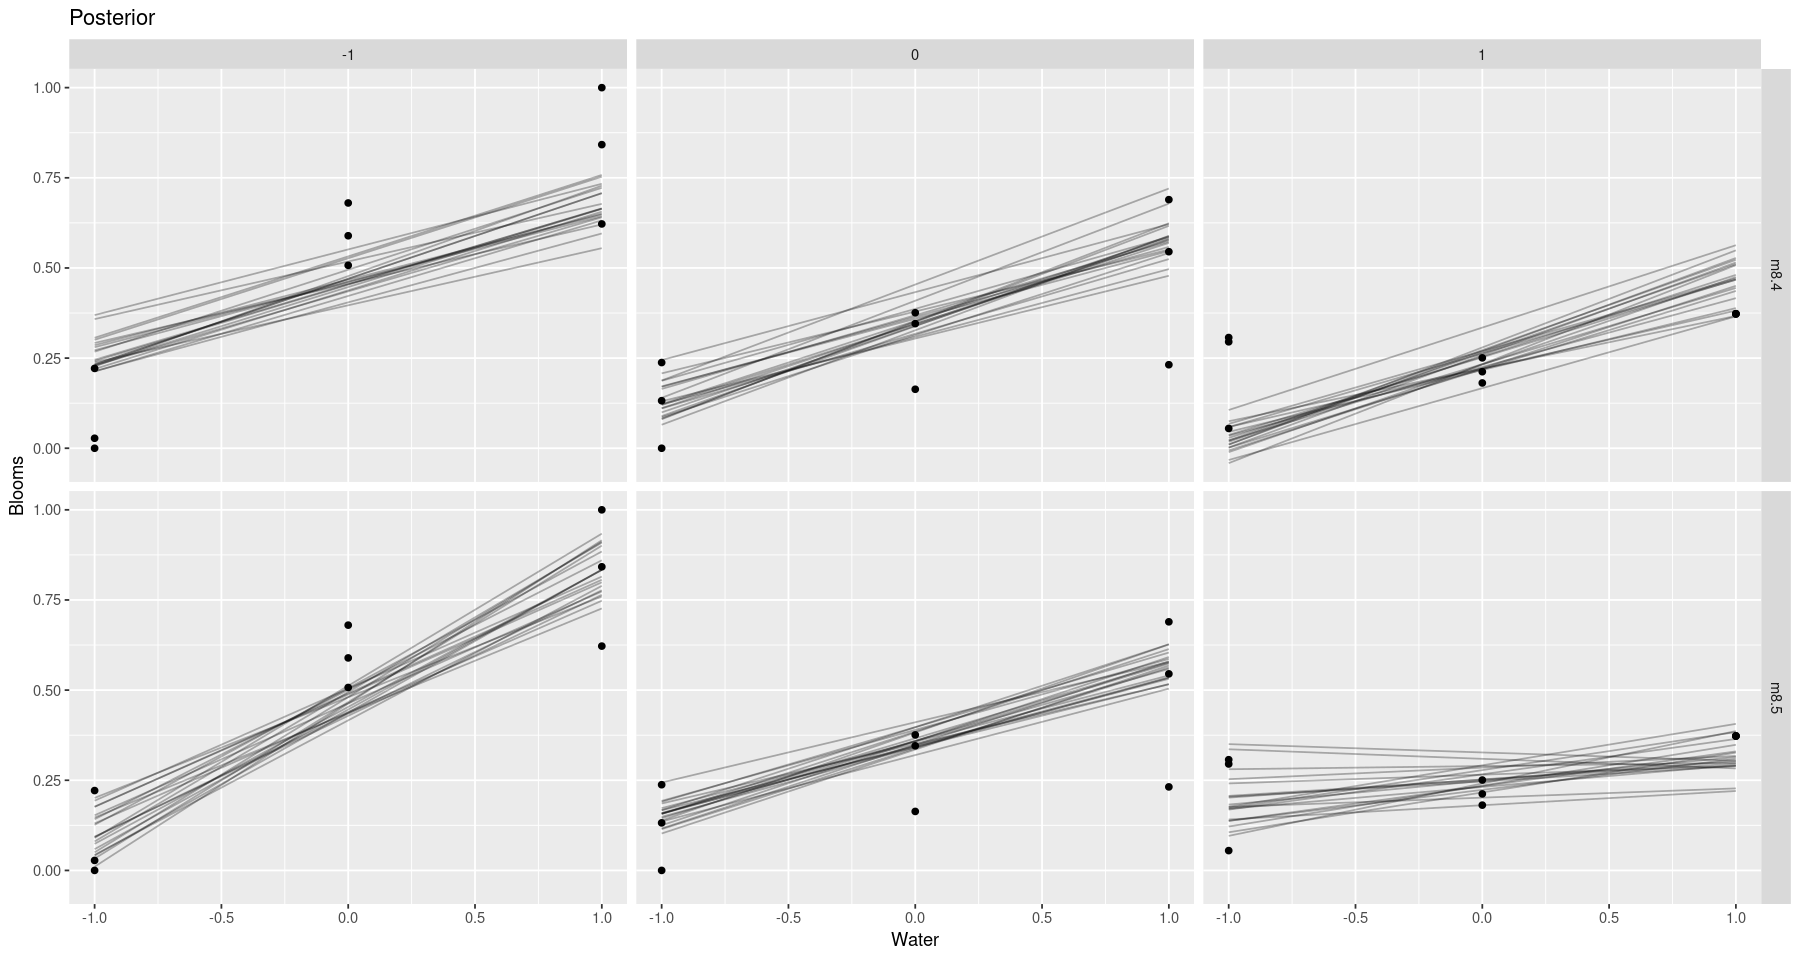

In [97]:
plot_df <- data.frame(
    water_cent = double(),
    blooms_std = double(),
    shade_cent = integer(),
    group = integer(),
    model = character()
)

# m8.4 information
for (shade in -1:1) {
    mu <- link(m8.4, data=data.frame(shade_cent=shade, water_cent=-1:1))
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i, model="m8.4")
        plot_df <- rbind(plot_df, new_df)
    }
}

# m8.5 information
for (shade in -1:1) {
    mu <- link(m8.5, data=data.frame(shade_cent=shade, water_cent=-1:1))
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i, model="m8.5")
        plot_df <- rbind(plot_df, new_df)
    }
}

options(repr.plot.width=15, repr.plot.height=8)
ggplot() +
    geom_point(data=d, aes(water_cent, blooms_std)) +
    geom_line(data=plot_df, aes(water_cent, blooms_std, group=group), alpha=0.3) +
    facet_grid(vars(model), vars(shade_cent)) +
    xlab("Water") + 
    ylab("Blooms") +
    ggtitle("Posterior")

In the top one (no interaction), the slope doesn't vary, so it 'believes' that water is always helpful. On the other hand, in the interaction model, it can vary - we can see that water is very helpful when there's no shade, but has very little effect when there is a lot of shade.

### Plotting prior predictions

We can use the same technique to plot the prior predictions!

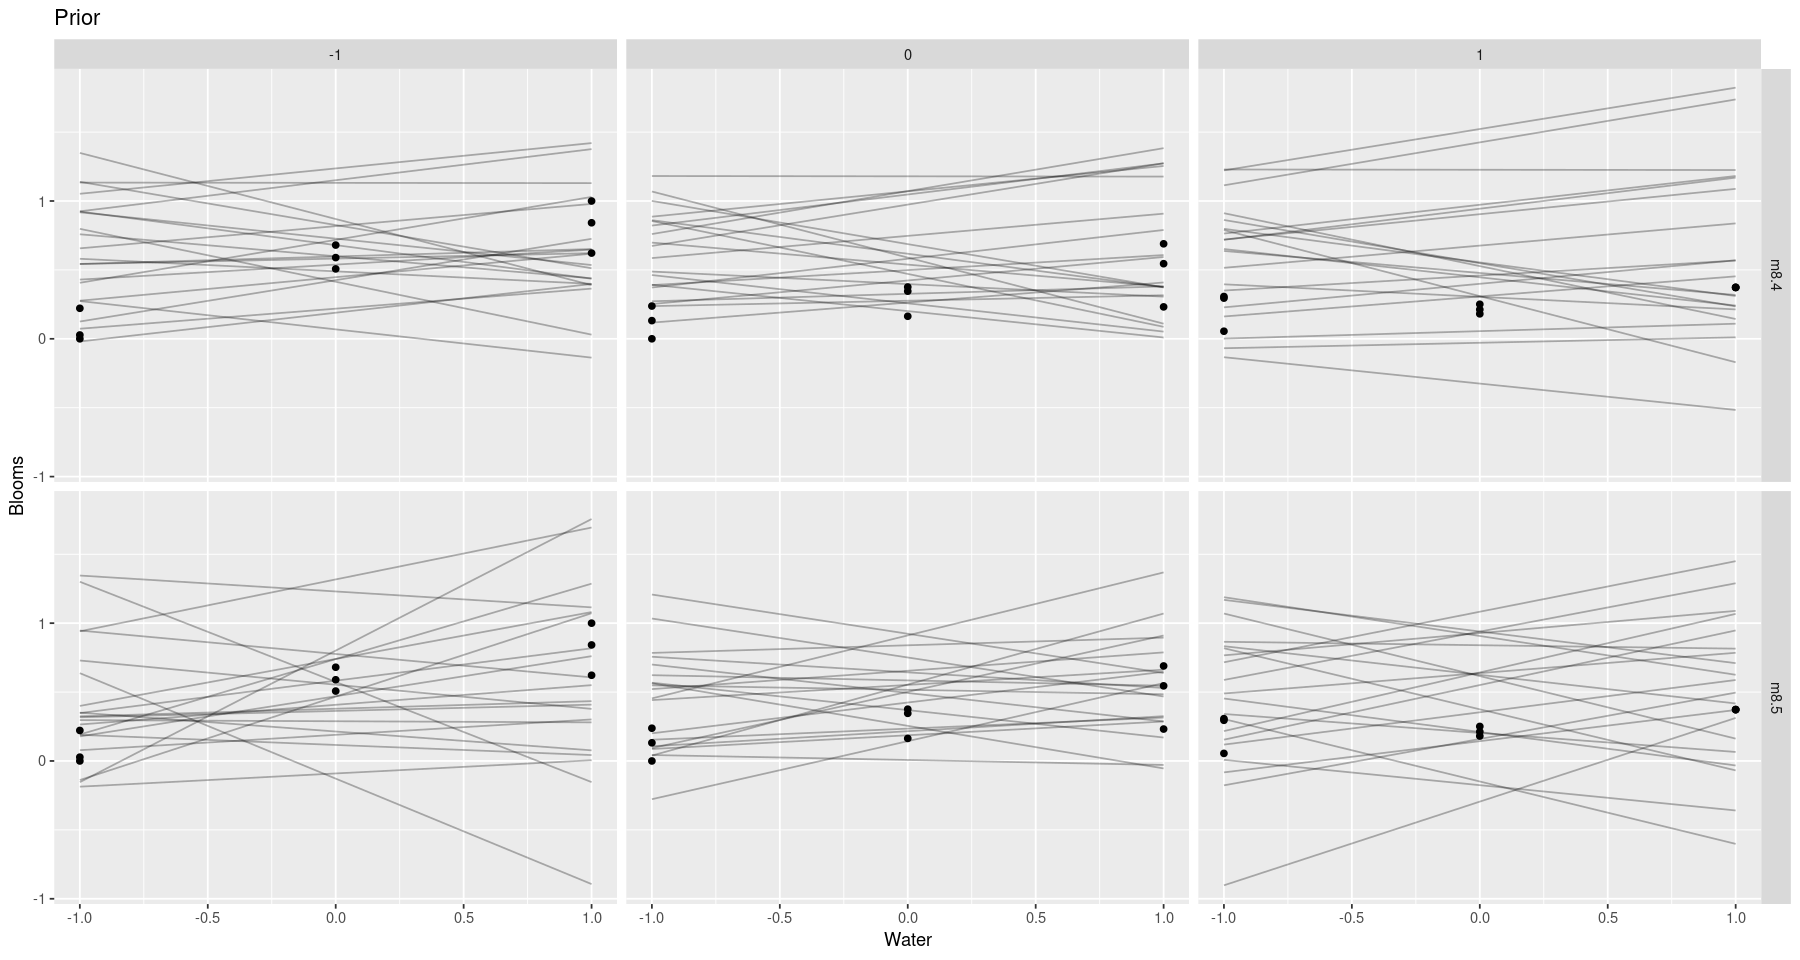

In [98]:
set.seed(7)
plot_df <- data.frame(
    water_cent = double(),
    blooms_std = double(),
    shade_cent = integer(),
    group = integer(),
    model = character()
)

prior_8.4 <- extract.prior(m8.4)
for (shade in -1:1) {
    mu <- link(m8.4, data=data.frame(shade_cent=shade, water_cent=-1:1), post=prior_8.4)
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i, model="m8.4")
        plot_df <- rbind(plot_df, new_df)
    }
}
prior_8.5 <- extract.prior(m8.5)
for (shade in -1:1) {
    mu <- link(m8.5, data=data.frame(shade_cent=shade, water_cent=-1:1), post=prior_8.5)
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i, model="m8.5")
        plot_df <- rbind(plot_df, new_df)
    }
}

ggplot() +
    geom_point(data=d, aes(water_cent, blooms_std)) +
    geom_line(data=plot_df, aes(water_cent, blooms_std, group=group), alpha=0.3) +
    facet_grid(vars(model), vars(shade_cent)) +
    xlab("Water") + 
    ylab("Blooms") +
    ggtitle("Prior")

Not such great priors, as we expected. Probably the best you can say is that they don't bias the effects to either positive or negative and they weakly constrain the results to be plausible.

## Practice

#### 8E1
For each of the causal relationships below, name a hypothetical third variable that would lead to an interaction effect
1. Bread dough rises because of yeast
1. Education leads to higher income
1. Gasoline makes the car go

1. A third variable could be the temperature: too low and the yeast will never rise (no matter how much there is), and the same with if it's too hot.
1. An interaction variable could be the GDP of the country you're in - if it is very low, then your chances of having a higher income are low too, no matter how well educated you are.
1. An interaction variable could be whether the brakes are on - if they are, then no amount of gas will make it go!

#### 8E2
Which of the following explanations invokes an interaction?
1. Caramelizing onions requires cooking over low heat and making sure the onions do not dry out
1. A car will go faster when it has mor cylinders or when it has a better fuel injector
1. Most people get their political beliefs from their parents, unless they get them instead from their friends
1. Intelligent animal species tend to be either highly social or have minupulative appendages (hands, tentacles, &c.)

1. Yes - requires the interaction of low heat and moisture
1. No - either one will make it go faster, regardless of the other
1. No - their beliefs are coming from either / or, not the interaction between them
1. No - Again, these are independent.

#### 8E3
for each of the relationships above, write a linear model that expresses the stated relationship

1. $c = \alpha + \beta_h * h + \beta_m * m + \beta_{hm} * m * h$, where $h$ is the temperature and $m$ is the moisture level.
1. $s = \alpha + \beta_c * c + \beta_f * f$, where $c$ is the number of cylinders and $f$ is a measure of the quality of the fuel injectors
1. $b = \alpha + \beta_p * p + \beta_f * f$, where $p$ is some measure of your parents' political beliegs and $f$ is a measure of your friends' beliefs
1. $I = \alpha + \beta_S * S + \beta_M * M$, where $S$ is a measure of sociality and $M$ is a measure of manipulativeness of appendages.

#### 8M1
Recall the tulips example from the chapter. Suppose another set of treatment adjusted the temperature in the greenhouse over two levels: cold and hot. The data in the chapter were collected at the cold temperature. You find that none of the plant growin under the hot temperature developed any blooms at all, regardless of the water and shade levels. Can you explain this result in terms of interactions between water, shade, and temperature?

Yes - tulips are a cool-season plant. Just like there is an interaction between light and water, there is one with temperature - if it is too high or too low, then no amount of the others will make a difference.

#### 8M2
Can you invent a regression equation that would make the bloom size zero, whenever the temperature is hot?

Yes - we could multiply the entire model by an indicator variable of whether the temperature is hot ($H=1$) or cold ($H=0$). So something like

$$
b = H * (\text{rest of the model here})
$$

#### 8M3
In parts of North America, ravens depend upon wolves for their food. This is because ravens are carnivorous, but cannot usually kill or open carcasses of prey. Wolves can and do kill and tear open animals, and they tolerate ravens co-feeding at theis kills. This species relationship is generally descibed as a "species interaction". Can you invent a hypothetical set of data on raven population size in which this relationsup would manifest as a statistical interaction? Do you think that biological interaction would be linear? Why or why not?

Let's assume that the raven population is dependent on both the raw amounts of food and the amount of wolves. This means that if there is a lot of food, ravens will generally do OK even if there are no wolves, but adding in the wolves will increase the amount that is available for them to eat. Then our model will look something like as follows:

$$
\begin{align*}
R_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_F * F_i + \beta_W * W_i + \beta_{FW}*F_i * W_i \\
\end{align*}
$$

where $R$ is the raven population, $F$ is the general availability of food, and $W$ is the size of the wolf population. We can simulate this data:

In [99]:
NUM_SAMPLES <- 30
SIGMA = 0.2
F <- seq(from=0, to=1, length.out=NUM_SAMPLES)
W <- seq(from=0, to=1, length.out=NUM_SAMPLES)
R <- F + W + F * W + rnorm(NUM_SAMPLES, 0, 1)

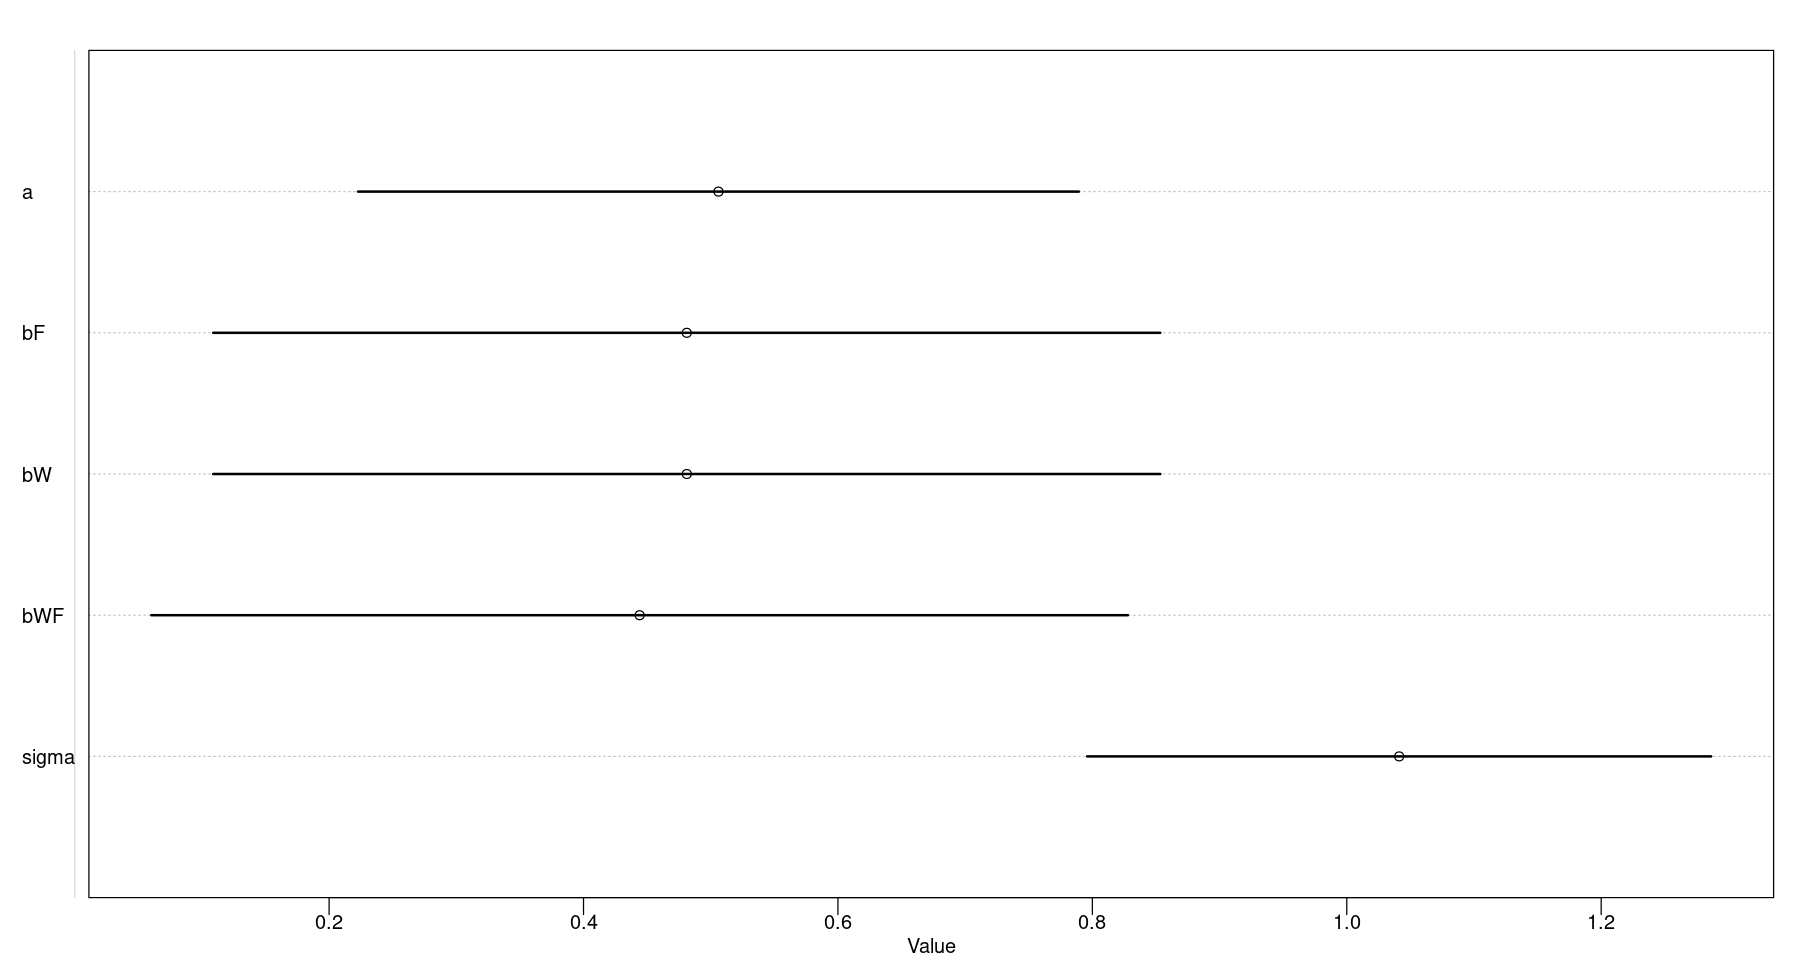

In [100]:
# now to test it
ravens_data <- data.frame(
    F=F,
    W=W,
    R=R
)
m8m3 <- quap(
    alist(
        R ~ dnorm(mu, sigma),
        mu <- a + bF * F + bW * W + bWF * W * F,
        a ~ dnorm(0, 0.25),
        bF ~ dnorm(0, 0.25),
        bW ~ dnorm(0, 0.25),
        bWF ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=ravens_data
)
plot(precis(m8m3))

So yes, this shows an interaction effect. All else being equal, I can imagine this being a linear relationship - if there are twice as many wolves then each of those would be taking a proportionaly larger amount of prey, and so that would make more available to the ravens.

#### 8M4
Repeat the tulips analysis, but now use priors that constrain the effect of water to be positive and the effect of shade to be negative. Use prior predictive simulation. What do these prior assumptions mean for the interaction prior, if anything?

For the interaction prior: once again, we'll go with the idea that the strongest effect is one which makes water have zero effect. Then

$$
\beta_w + \beta_{WS}S_I = 0
$$

Again, setting $S_I=1$ (strongest shade), we get $\beta_{ WS } = -\beta_w$. Since our prior mean for $\beta_w = 0.5$, we want $\beta_{WS} = -0.5$.

In [101]:
m8m4 <- quap(
    alist(
        blooms_std ~ dnorm(mu, sigma),
        mu <- a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent,
        a ~ dnorm(0.5, 0.25),
        bw ~ dnorm(0.5, 0.25),
        bs ~ dnorm(-0.5, 0.25),
        bws ~ dnorm(-0.5, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)

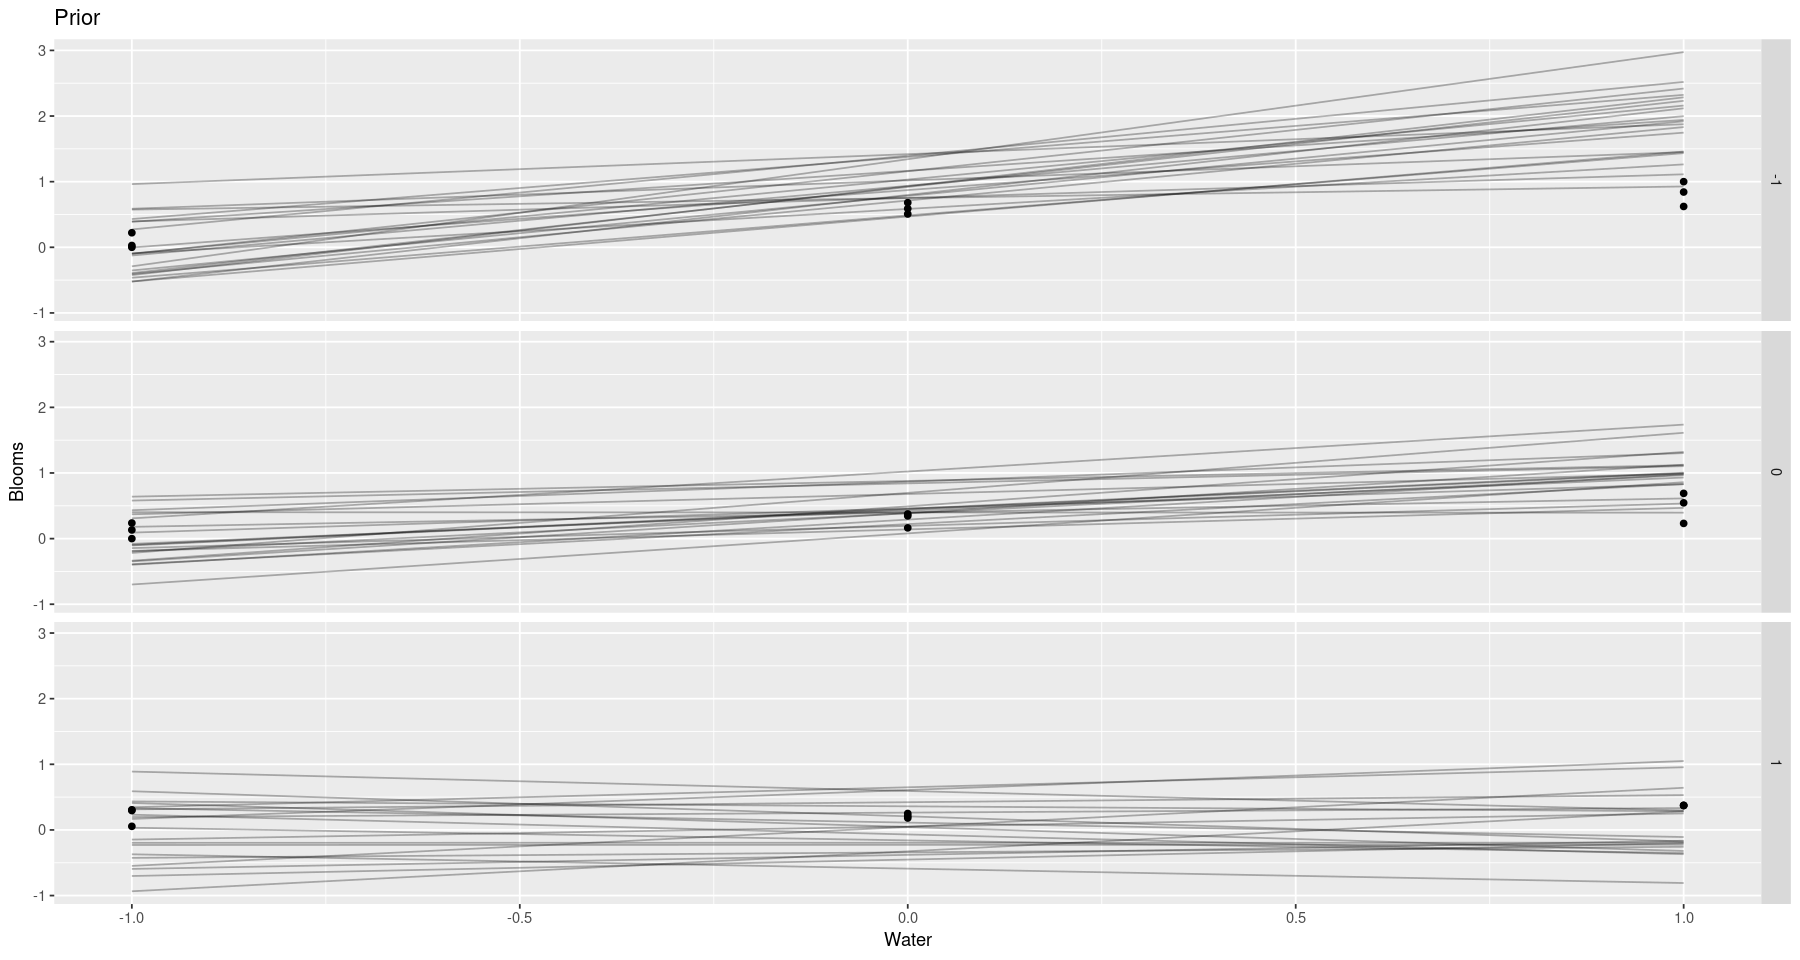

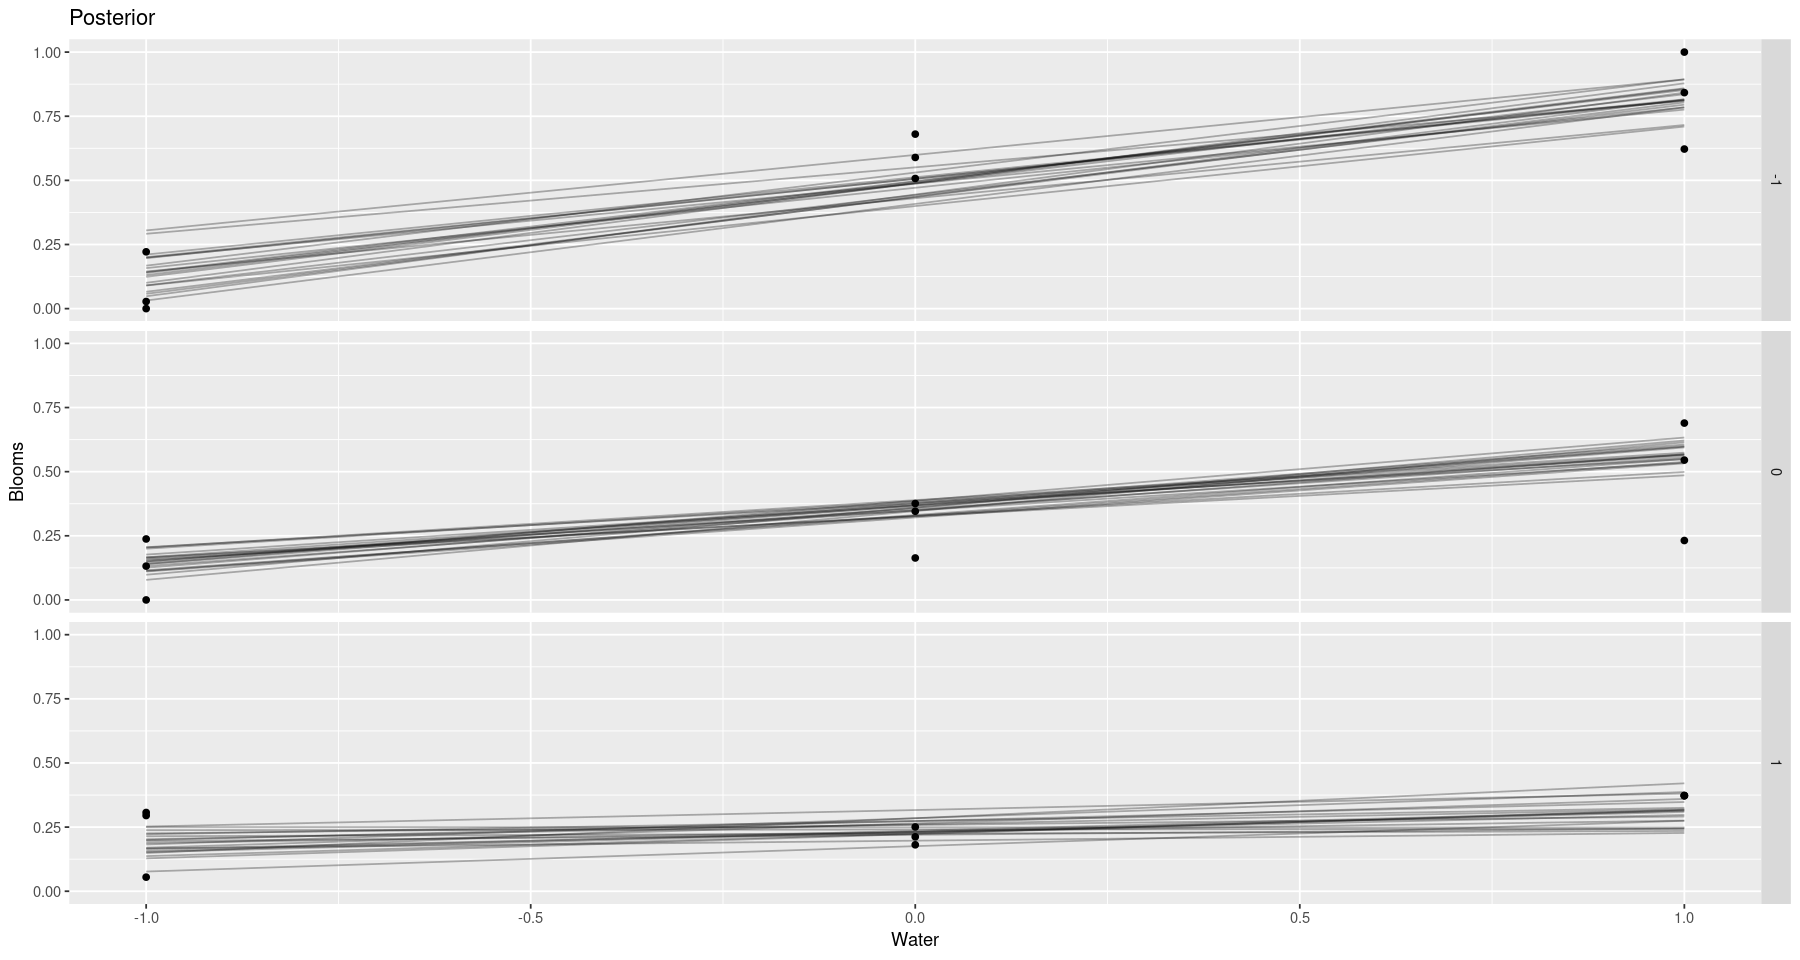

In [102]:
plot_df <- data.frame(water_cent=double(), blooms_std=double(), shade_cent=double(), group=integer())
prior_m8m4 <- extract.prior(m8m4)
for (shade in -1:1) {
    mu <- link(m8m4, data=data.frame(shade_cent=shade, water_cent=-1:1), post=prior_m8m4)
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i)
        plot_df <- rbind(plot_df, new_df)
    }
}

ggplot() +
    geom_point(data=d, aes(water_cent, blooms_std)) +
    geom_line(data=plot_df, aes(water_cent, blooms_std, group=group), alpha=0.3) +
    facet_grid(vars(shade_cent)) +
    xlab("Water") + 
    ylab("Blooms") +
    ggtitle("Prior")

## Posterior

plot_df <- data.frame(water_cent=double(), blooms_std=double(), shade_cent=double(), group=integer())
for (shade in -1:1) {
    mu <- link(m8m4, data=data.frame(shade_cent=shade, water_cent=-1:1))
    for (i in 1:20) {
        new_df <- data.frame(water_cent=-1:1, blooms_std=mu[i,], shade_cent=shade, group=10*shade + i)
        plot_df <- rbind(plot_df, new_df)
    }
}

ggplot() +
    geom_point(data=d, aes(water_cent, blooms_std)) +
    geom_line(data=plot_df, aes(water_cent, blooms_std, group=group), alpha=0.3) +
    facet_grid(vars(shade_cent)) +
    xlab("Water") + 
    ylab("Blooms") +
    ggtitle("Posterior")

In [103]:
precis(m8m4)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.3579862,0.02394950,0.31971024,0.39626210
bw,0.2135758,0.02928128,0.16677870,0.26037300
bs,-0.1203097,0.02929603,-0.16713044,-0.07348902
bws,-0.1533638,0.03576801,-0.21052797,-0.09619960
sigma,0.1250064,0.01700571,0.09782803,0.15218485


This has a slight effect on the interaction parameter.

#### 8H1

Return to the `data(tulips)` example in the chapter. Now include the `bed` variable as a predictor in the interaction model. Don't interact `bed` with the other predictors; just include it as a main effect. Note that `bed` is categorical, so to use it properly you'll need to either construct dummy variables or an index variable, as described in chapter 5.

In [104]:
d$bed
d$bed_num <- ifelse(d$bed == 'a', 1, d$bed)
d$bed_num <- ifelse(d$bed == 'b', 2, d$bed)
d$bed_num <- ifelse(d$bed == 'c', 3, d$bed)
d$bed_num

[1] a a a a a a a a a b b b b b b b b b c c c c c c c c c
Levels: a b c

[1] 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3

In [105]:
m8h1 <- quap(
    alist(
        blooms_std ~ dnorm(mu, sigma),
        mu <- a + bw * water_cent + bs * shade_cent + bb[bed_num] * bed_num + bws * water_cent * shade_cent,
        a ~ dnorm(0.5, 0.25),
        bw ~ dnorm(0, 0.25),
        bs ~ dnorm(0, 0.25),
        bb[bed_num] ~ dnorm(0, 0.25),
        bws ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m8h1, depth=2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.387428428,0.16345856,0.12619008,0.64866677
bw,0.207437069,0.02536622,0.16689695,0.24797719
bs,-0.113848869,0.02536160,-0.15438160,-0.07331614
bb[1],-0.116455837,0.16405627,-0.37864945,0.14573777
bb[2],0.003389892,0.08327055,-0.12969253,0.13647232
bb[3],0.006582216,0.05566993,-0.08238908,0.09555351
bws,-0.143893326,0.03098525,-0.19341375,-0.09437291
sigma,0.108149529,0.01467928,0.08468920,0.13160985


For all of the `bb` coefficients, they seem to hover around 0, indicating to us that maybe the bed doesn't have much of an effect on the number of blooms.

#### 8H2
Use WAIC to compare the model from 8H1 to a model that omits `bed`. What do you infer from this comparison? can you reconcile the WAIC results with the posterior distribution of the `bed` coefficients?

In [106]:
compare(m8.5, m8h1)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m8h1,-22.56145,10.24801,0.000000,NA,10.225422,0.6465465
m8.5,-21.35366,10.55084,1.207786,8.439126,6.930282,0.3534535


Here we see that the `m8h1` model is slightly better (1.6), but the `dSE` is 7.7, so it's not appreciably better. The models are roughly equivalent,which is in line with the finding that the bed number doesn't really affect the model too much.

#### 8H3
Consider, again, the `data(rugged)` data on evonomic development and terrain ruggedness. On of the African countries in that example, Seychelles, is far outside the cloud of other nations, being a rare country with both relatively high GDP and high ruggedness. Seychelles is also unusual in that it is a group of islands far from the coast of mainland Africa, and its main economic activity is tourism.

a) Focus on model m8.5  [NB this should be 8.3 - 8.5 is the tulip one] from this chapter. Use WAIC pointwise penalties and PSIS Pareto-$k$ values to measure relative incluence of each country. By these criteria, is Seychelles influencing the results? Are there other nations that are relatively influential? If so, can you explain why?

b) Now use robust regression, as described in the previous chapter. Modify `m8.5` [NB: `m8.3`] to use a Student-t distribution with $\nu=2$. Does this change the results in a substantial way?

In [107]:
# comparison_data$country <- dd$country
waic_data <- WAIC(m8.3, pointwise=T)
psis_data <- PSIS(m8.3, pointwise=T)

comparison_data <- cbind(dd$country, waic_data, psis_data)

comparison_data

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



dd$country,WAIC,lppd,penalty,std_err,PSIS,lppd,penalty,std_err,k
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Angola,-2.5621804,1.2841356,0.003045424,15.17878,-2.5678652,1.2839326,0.002982210,15.31781,-0.0904058847
Albania,-2.4221347,1.2183020,0.007234686,15.17878,-2.4332127,1.2166063,0.006803377,15.31781,0.1164936058
United Arab Emirates,-1.6801218,0.8493764,0.009315510,15.17878,-1.6777420,0.8388710,0.009292557,15.31781,0.1684758923
Argentina,-2.4307238,1.2191537,0.003791758,15.17878,-2.4333680,1.2166840,0.003648478,15.31781,0.1019437353
Armenia,-1.6254743,0.8307847,0.018047533,15.17878,-1.6431173,0.8215586,0.017573559,15.31781,0.0172241645
Antigua and Barbuda,-2.5637113,1.2849934,0.003137730,15.17878,-2.5671393,1.2835696,0.003109582,15.31781,-0.0755641782
Australia,-1.4746336,0.7562978,0.018981017,15.17878,-1.4737432,0.7368716,0.020252918,15.31781,0.1240474677
Austria,1.1603749,-0.4220944,0.158092987,15.17878,1.2198133,-0.6099067,0.160659992,15.31781,0.1358448151
Azerbaijan,-1.3367322,0.6795020,0.011135938,15.17878,-1.3480917,0.6740459,0.010375584,15.31781,0.0334377941


In [108]:
# now we want the one with a Pareto-k value which is too high
comparison_data[comparison_data$k > 0.5,]

,dd$country,WAIC,lppd,penalty,std_err,PSIS,lppd,penalty,std_err,k
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
93,Lesotho,-1.253275,0.89670237,0.2700650,15.17878,-1.101587,0.5507933,0.3437452,15.31781,0.6829880
145,Seychelles,1.320141,-0.04809972,0.6119706,15.17878,1.434228,-0.7171141,0.6714482,15.31781,0.5422728


So it looks like both Lesotho and the Seychelles are outliers here. Lesotho is possibly influencing it so much simply because its GDP is not all that unusual, but its ruggedness is? Unclear.

In [109]:
m8.3_robust <- quap(
    alist(
        log_gdp_std ~ dstudent(2, mu, sigma),
        mu <- a[cid] + b[cid] * (rugged_std - 0.215),
        a[cid] ~ dnorm(1, 0.1),
        b[cid] ~ dnorm(0, 0.3),
        sigma ~ dexp(1)
    ),
    data=dd
)

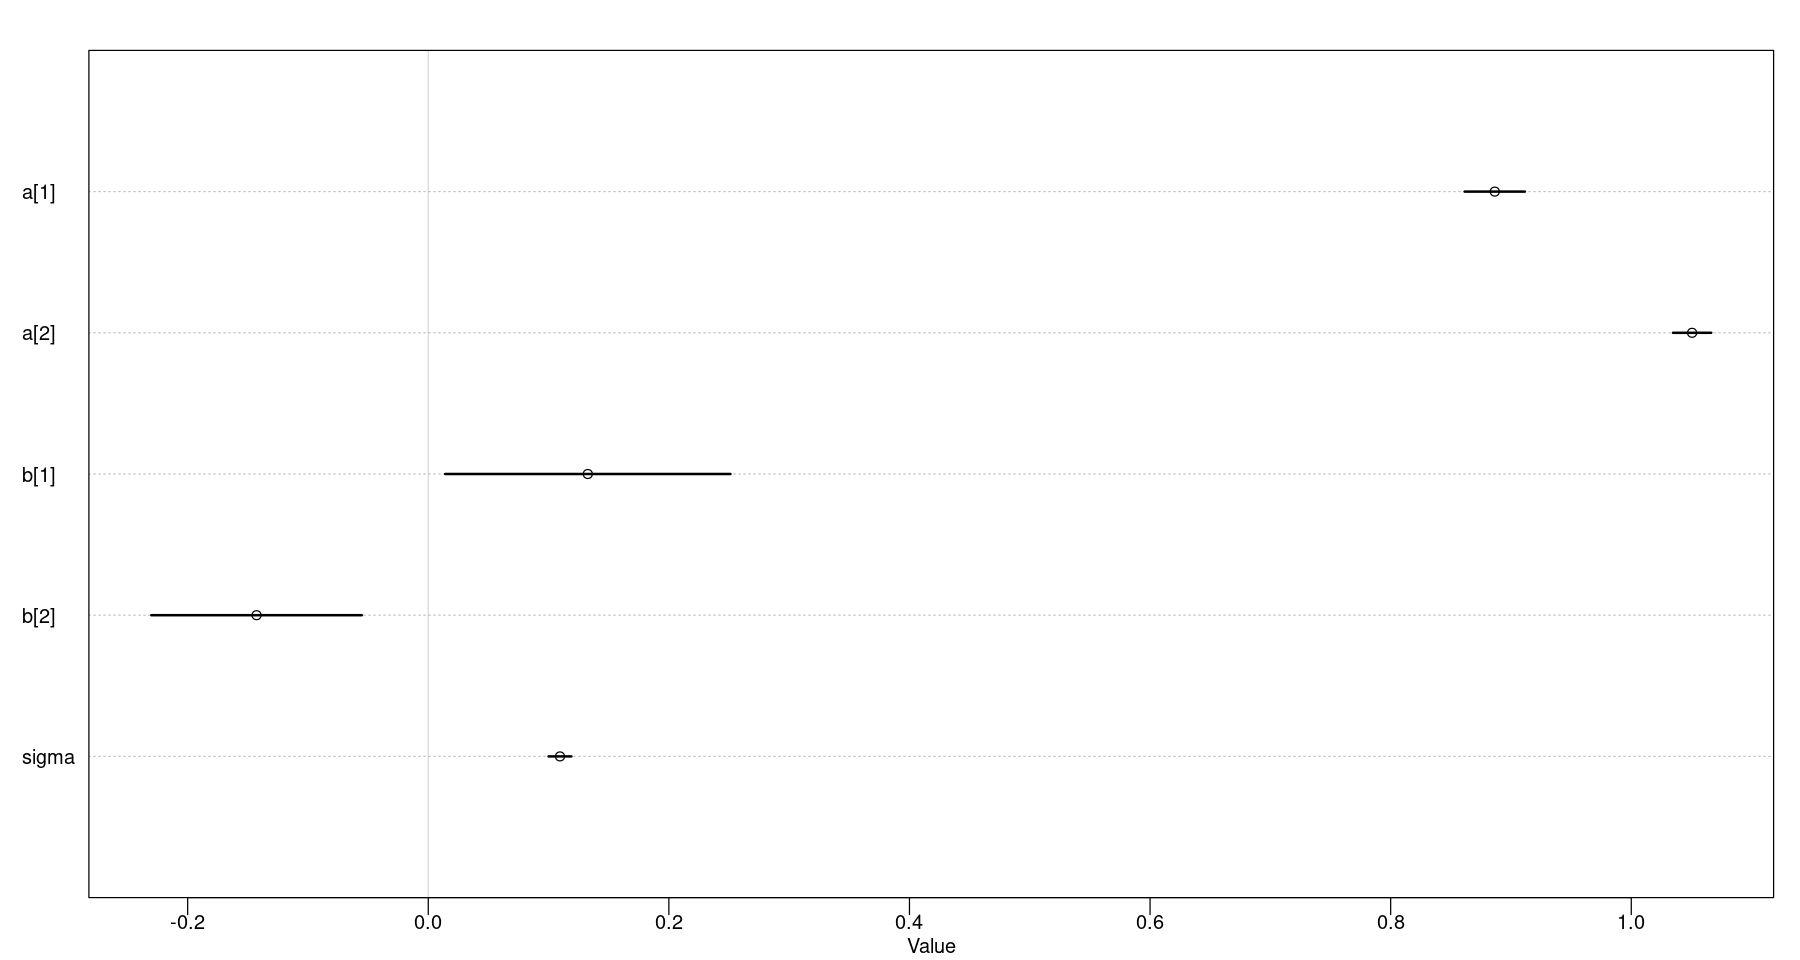

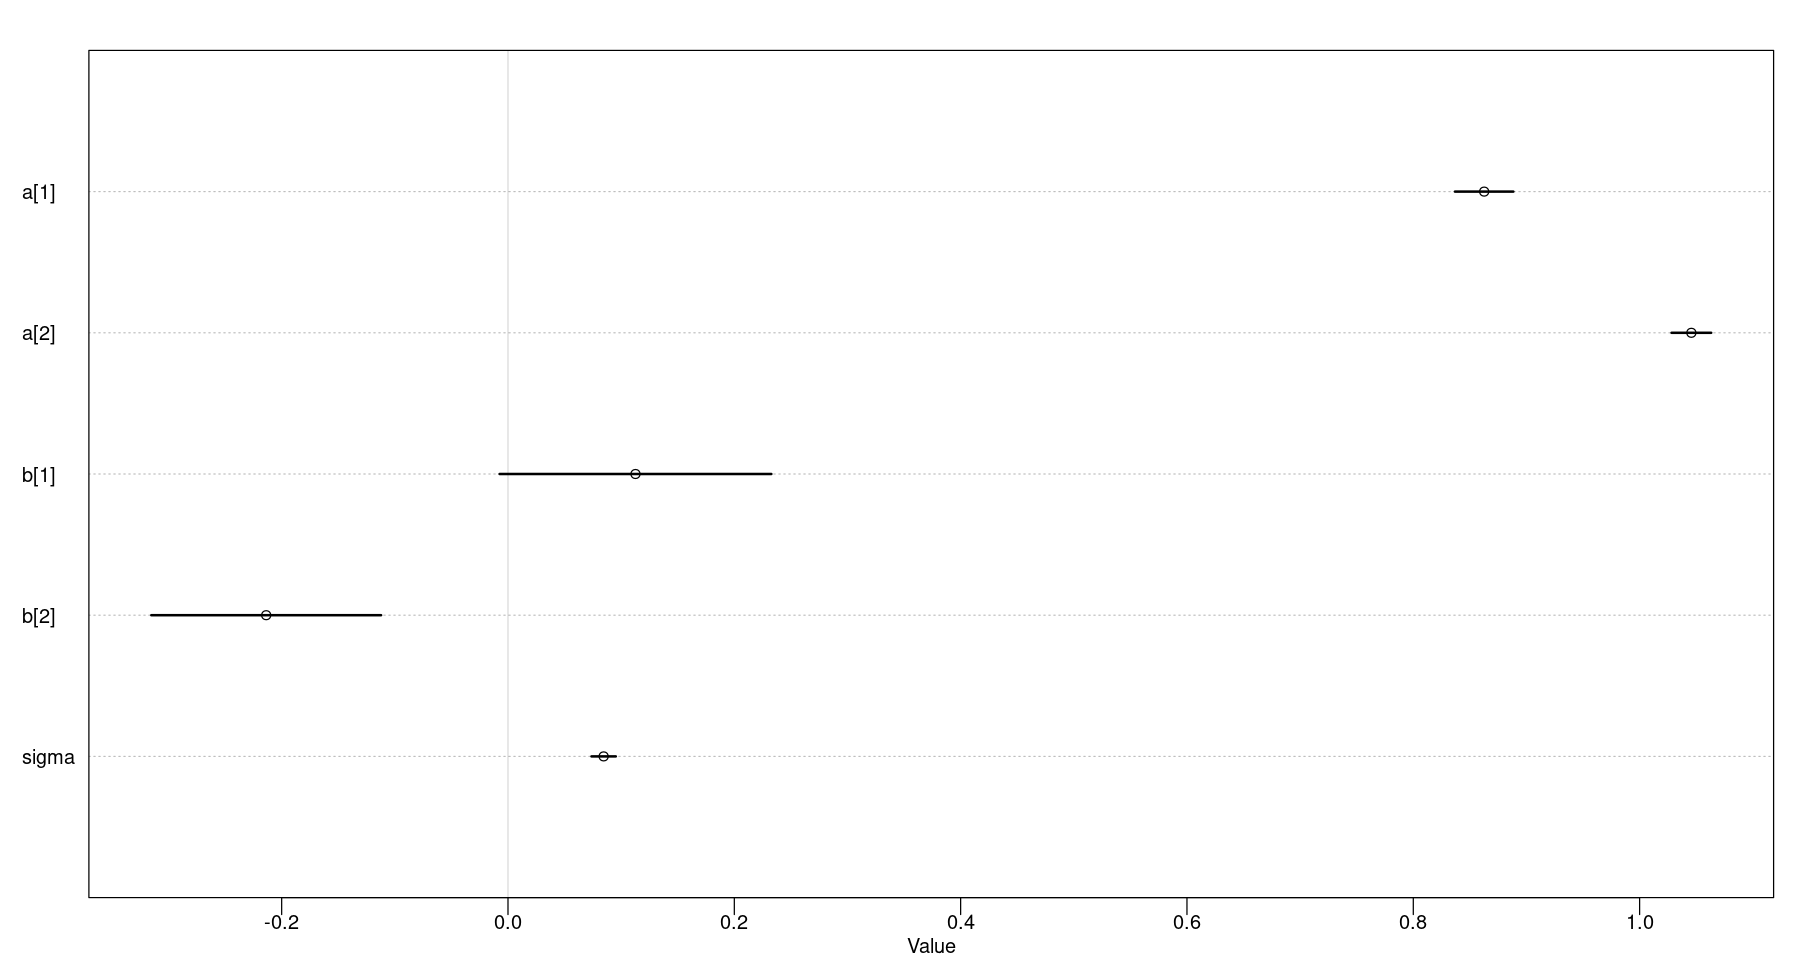

In [110]:
plot(precis(m8.3, depth=2))
plot(precis(m8.3_robust, depth=2))

In [111]:
coeftab(m8.3, m8.3_robust)

      m8.3    m8.3_robust
a[1]     0.89    0.86    
a[2]     1.05    1.05    
b[1]     0.13    0.11    
b[2]    -0.14   -0.21    
sigma    0.11    0.08    
nobs      170     170    

So no, this doesn't seem to have affected the results very much at all.

#### 8H4
The values in `data(nettle)` are data on language diversity in 74 nations. 
- `country`: name of the country
- `num.lang`: Number of recognized languages spoken
- `area`: area in square kilometres
- `k.pop`: population in thousands
- `num.stations`: number of weather stations the provide data for the next two columns
- `mean.growing.season`: average length of the growing season, in months
- `sd.growing.season`: standard deviation of length of growing season, in months

Use these data to evaluate the hypothesis that language diversity is partly a product of food security. The idea is that if there is lots of food, then social groups can be smaller and more self-sufficient, leading to more languages. Use number of languages per capita as the outcome:

```R
d$lang.per.cap <- d$num.lang / d$k.pop
```

Use the log of this as the regression outcome. Very open-ended question. Just try to honestly evaluate the effect of both `mean.growing.season` and `sd.growing.season`, as well as they two-way interaction. Three things to help:

a) evaluate the hypothesis that language diversity (`log(lang.per.cap)`) is positively associate with the average length of the growing season, `mean.growing.season`. Consider `log(area)` as a covariate (not an interaction). Interpret your results.

b) Now evaluate the hypothesis that language diversity is negatively ssociated with the standard deviation of length of growing season, `sm.growing.season`. The idea here is that uncertainty in growing season will lead to insurance in the form of larger social groups. Again, condier `log(area)` as a covariate, not an interaction. Interpret your results.

c) Finally, evaluate the hypothesis that `mean.growing.season` and `sd.growing.season` interact to synergistically reduce number of languages. The idea is that, in nations with longer average growing seasons, high variance makes storage and redistrivution even more important that it would e otherwise. that way, people can cooperate to preserve and protect windfalls to be used during the droghts.

In [126]:
data(nettle)
d <- nettle
d$lang.per.cap <- d$num.lang / d$k.pop
d$log.lang.per.cap <- log(d$lang.per.cap)
d$std.log.lang.per.cap <- d$log.lang.per.cap / max(d$log.lang.per.cap)
d$log.area <- log(d$area)
d$std.log.area <- d$log.area / max(d$log.area)
d$std.growing.season <- d$mean.growing.season / max(d$mean.growing.season)
d$std.sd.growing.season <- d$sd.growing.season / max(d$sd.growing.season)


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.5921720,0.5248311,0.75339055,2.4309535
bA,0.3254743,0.2521447,-0.07750167,0.7284503
bG,0.2211754,0.2505414,-0.17923816,0.6215890
sigma,11.9139103,1.0056668,10.30666049,13.5211601


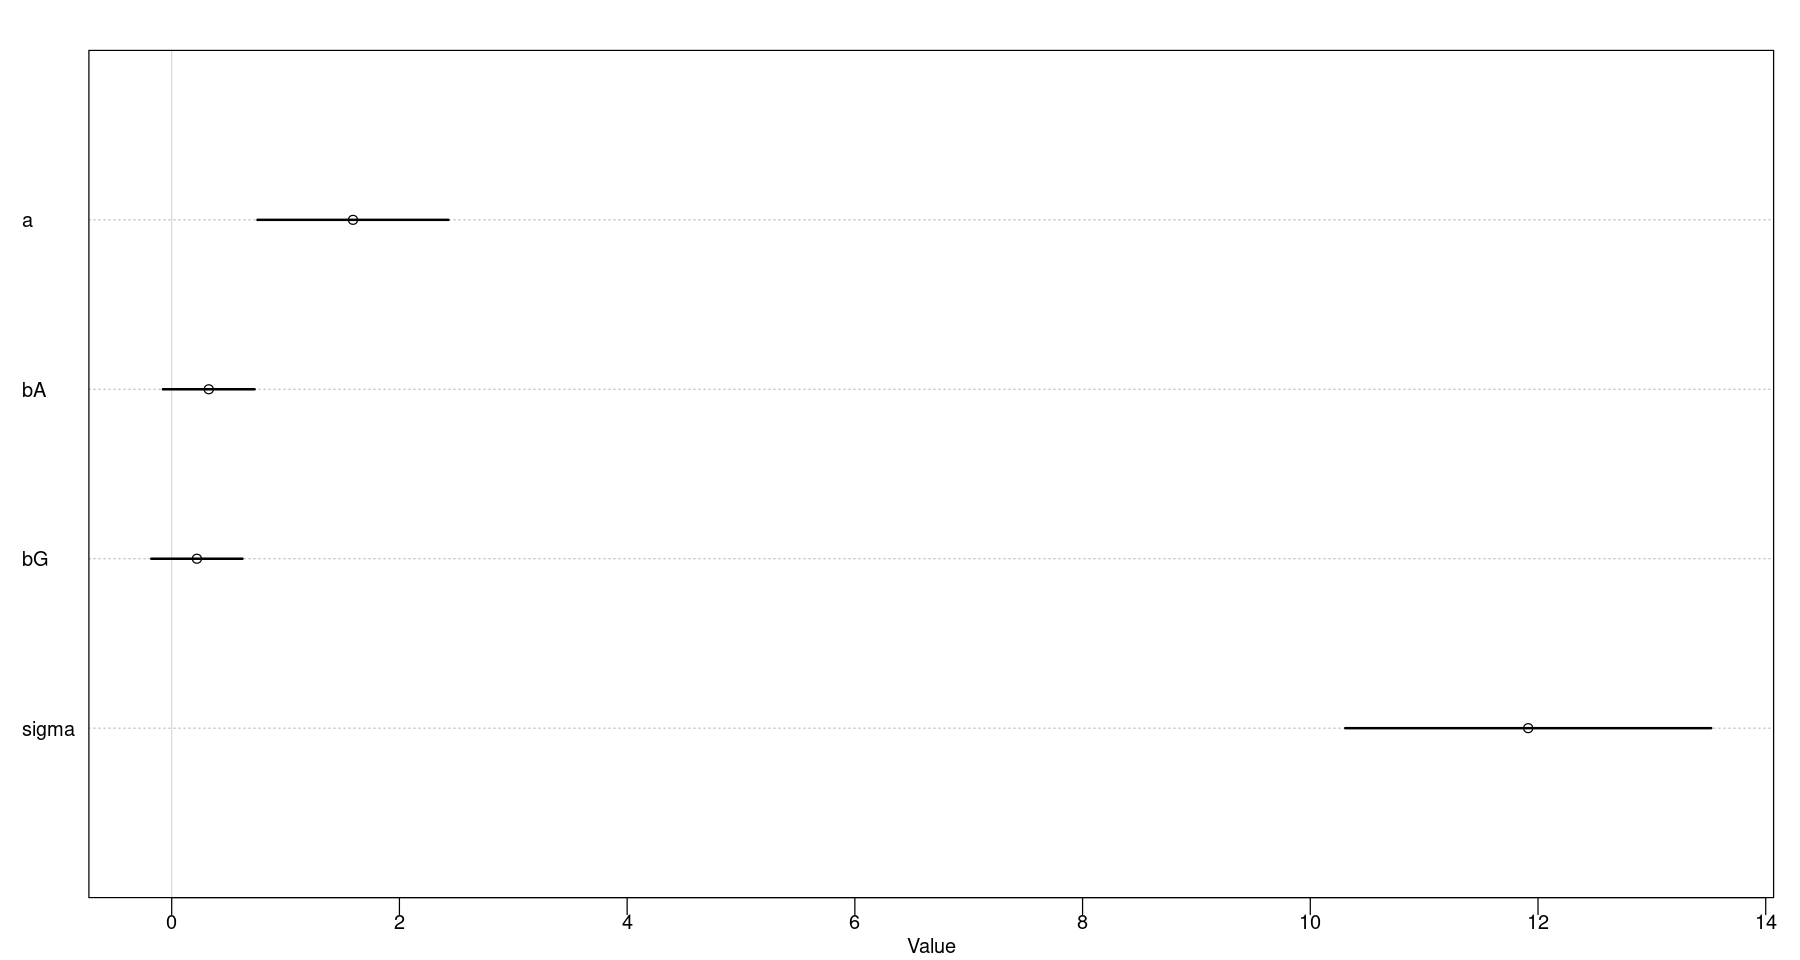

In [127]:
m8h4.a <- quap(
    alist(
        std.log.lang.per.cap ~ dnorm(mu, sigma),
        mu <- a + bA * std.log.area + bG * std.growing.season,
        a ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.25),
        bG ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m8h4.a)
plot(precis(m8h4.a))

So it looks like both the area and the length of the growing season are not really associated with the log number of languages per capita.


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.5845071,0.5245405,0.74619012,2.4228241
bA,0.3240114,0.2521144,-0.07891616,0.7269389
bS,0.1203791,0.2501955,-0.27948166,0.5202398
sigma,11.9915718,1.0044622,10.38624727,13.5968964


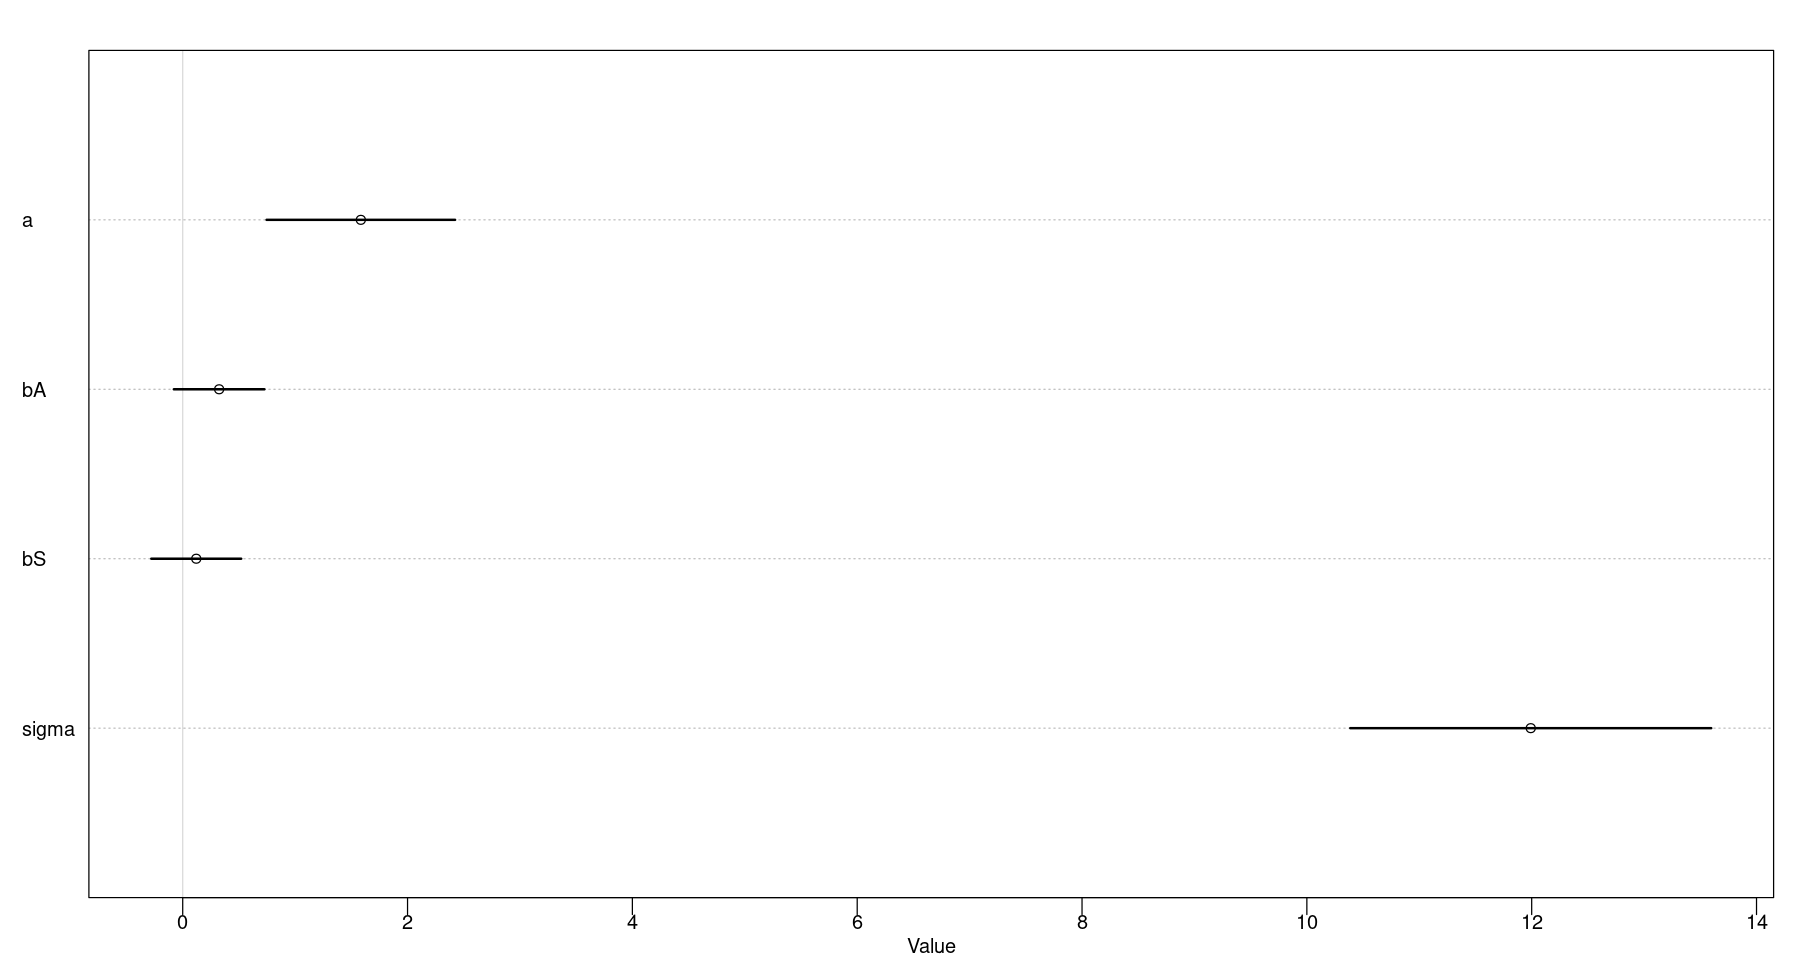

In [128]:
m8h4.b <- quap(
    alist(
        std.log.lang.per.cap ~ dnorm(mu, sigma),
        mu <- a + bA * std.log.area + bS * std.sd.growing.season,
        a ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.25),
        bS ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m8h4.b)
plot(precis(m8h4.b))

Again, we see that the area and the sd of the growing season are not really correlated with the number of languages per capita.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.59749659,0.5251105,0.75826864,2.4367245
bA,0.32643504,0.2521681,-0.07657837,0.7294484
bS,0.12112046,0.2502008,-0.27874873,0.5209896
bG,0.22185692,0.2505464,-0.17856459,0.6222784
bGS,0.07076869,0.2500404,-0.32884412,0.4703815
sigma,11.86771030,1.0064885,10.25914729,13.4762733


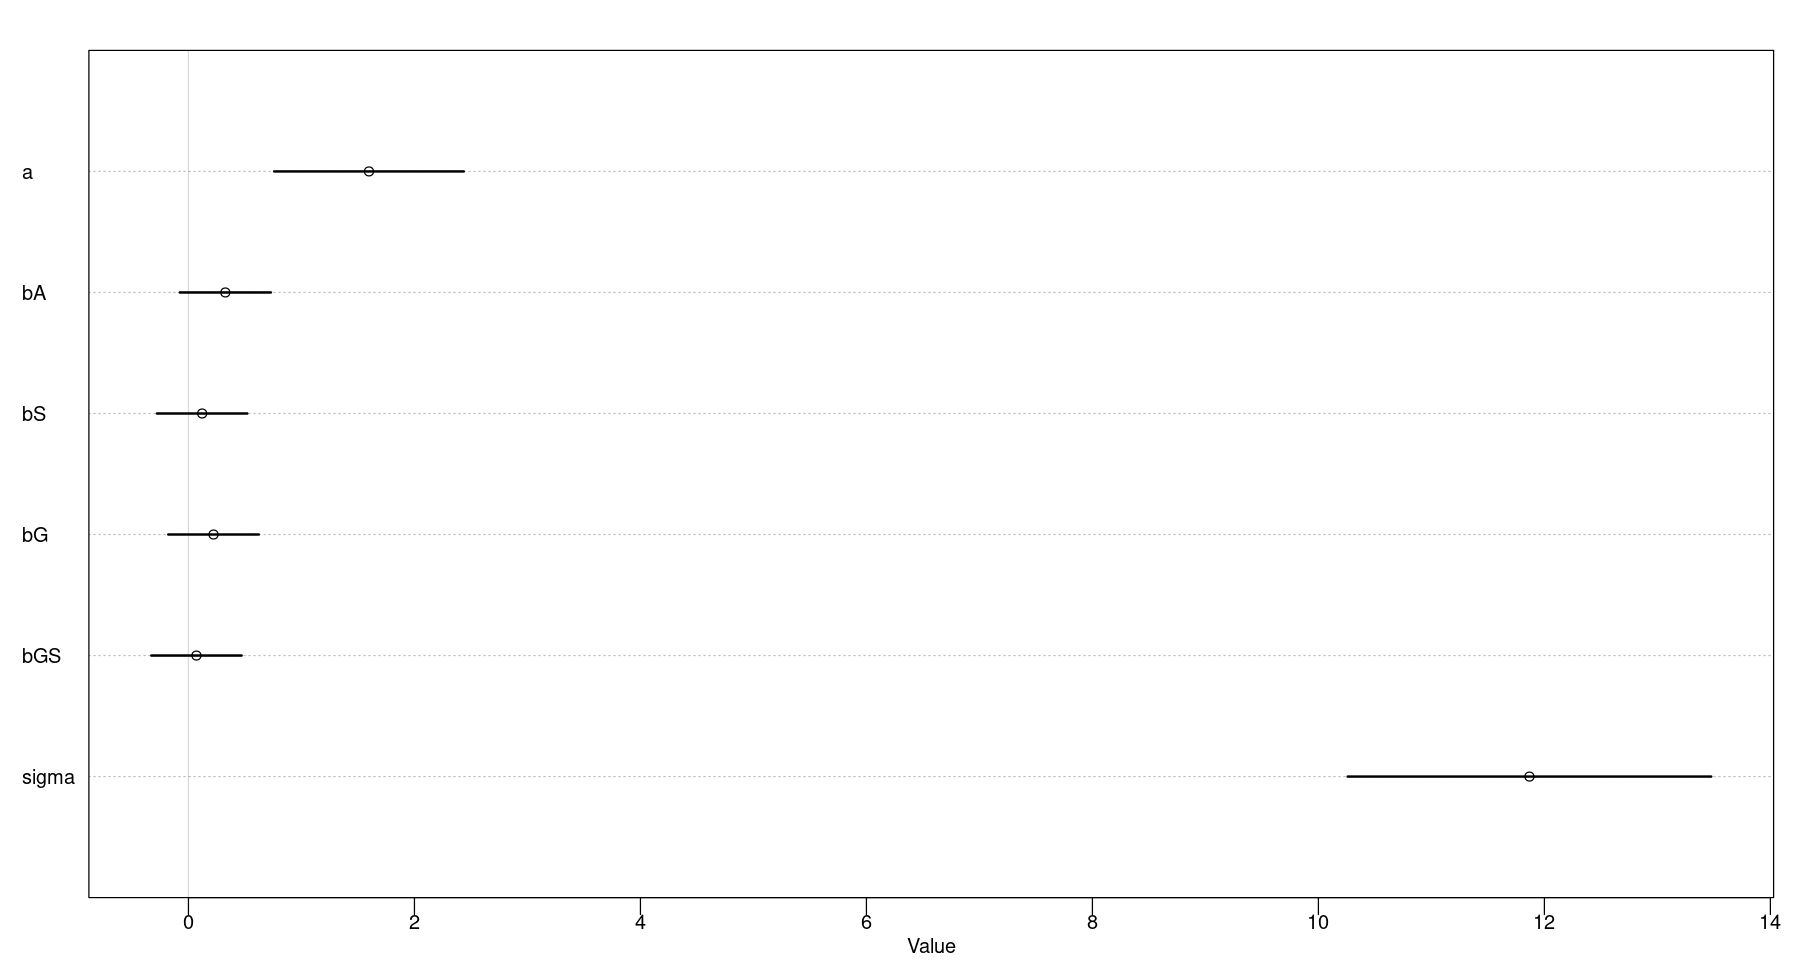

In [129]:
m8h4.c <- quap(
    alist(
        std.log.lang.per.cap ~ dnorm(mu, sigma),
        mu <- a + bA * std.log.area + bG * std.growing.season + bS * std.sd.growing.season + bGS * std.growing.season * std.sd.growing.season,
        a ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.25),
        bS ~ dnorm(0, 0.25),
        bG ~ dnorm(0, 0.25),
        bGS ~ dnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m8h4.c)
plot(precis(m8h4.c))

From this, it looks like this hypothesis is not really supported by the data.

#### 8H5
Consider the `data(wines2012)` data table. These data are expert ratings of 20 different French and American wines by 9 different American and French judges. Your goal is to model `score`, the subjective rating assigned by each judge to each wine. I recommend standardizing it. In this problem, condier only variation among judges and wines. Construct index variables of `judge` and `wine` and then use these index variables to construct a linear regression model. Justify your priors. You should the use these index variables to construct a linear regression model. Justify your priors. You should end up with 9 judge parameters and 20 wine parameters. How to you interpret the variation among the individual judges and individual wines? Do you notice any patterns, just by plotting the differences? Which judge gave the highest / lowest ratings? which wines were rated worst / best on average?

#### 8H6
Now consider three features of the winse and judges.
1. `flight`: whether the wine was white or red
1. `wine.amer`: indicator variable for American wines
1. `judge.amer`: indicator variable for American judges

Use indicator variables to model the influence of these features on the scores. Omit the individual judge and wine variables from 8H5. Do not include interaction effects yet. Again, justify your priors. What do you conclude about the differences among the wines and judges? Try to relate the results to the inferenes in the previous problem.

#### 8H7
Now consider two-way interactions among the three features. You should end up with three different interaction terms in your mode. These will be easier to buid if you use indicator variables. Agin, justify your priors. Explain what each inteaction means. By sure to interpret the model's prediction on the outcome scale (`mu`, the expected score)m not on the scale of individual parameters. You can use `link` to help with this, or just use your knowledge of the linear model instead. What do you conclude about the featurse and the scores? Can you relate the results of your models to the individual judge and wine interactions in 8H5?